In [113]:
!pip install -q --upgrade --force-reinstall ipykernel
!pip install -q -U numpy==1.24.3
!pip install -q -U numba scipy contourpy
!pip install -q -U matplotlib==3.7.0 scikit-learn shap phik

  error: subprocess-exited-with-error
  
  × Building wheel for matplotlib (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [585 lines of output]
      
      Edit mplsetup.cfg to change the build options; suppress output with --quiet.
      
      BUILDING MATPLOTLIB
            python: yes [3.13.0 (tags/v3.13.0:60403a5, Oct  7 2024, 09:38:07) [MSC
                        v.1941 64 bit (AMD64)]]
          platform: yes [win32]
             tests: no  [skipping due to configuration]
            macosx: no  [Mac OS-X only]
      
      C:\Users\a.vlasova\AppData\Local\Temp\pip-build-env-l_iilq_m\overlay\Lib\site-packages\setuptools\dist.py:804: SetuptoolsDeprecationWarning: The namespace_packages parameter is deprecated.
      !!
      
              ********************************************************************************
              Please replace its usage with implicit namespaces (PEP 420).
      
              See https://setuptools.pypa.io/en/latest/refer

In [114]:
!pip install -q phik
!pip install -q -U scikit-learn
!pip install -q --upgrade shap
!pip install -q matplotlib==3.7.0


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: C:\Program Files\Python313\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: C:\Program Files\Python313\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: C:\Program Files\Python313\python.exe -m pip install --upgrade pip
  error: subprocess-exited-with-error
  
  × Building wheel for matplotlib (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [585 lines of output]
      
      Edit mplsetup.cfg to change the build options; suppress output with --quiet.
      
      BUILDING MATPLOTLIB
            python: yes [3.13.0 (tags/v3.13.0:60403a5, Oct  7 2024, 09:38:07) [MSC
                        v.1941 64 bit (AMD64)]]
          platform: yes [win32]
             tests: no  [skipping due to configuration]
            macosx: no  [Mac OS-X only]
     

In [115]:
import sklearn
print(sklearn.__version__)

1.7.2


In [116]:
import pandas as pd
import seaborn as sns
import numpy as np
import shap
import matplotlib.pyplot as plt

In [117]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.metrics import (accuracy_score, 
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             roc_auc_score, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay, 
                             classification_report)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler, 
    OneHotEncoder, 
    OrdinalEncoder)
from sklearn.impute import SimpleImputer 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.tree import plot_tree

In [118]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.cluster import KMeans

In [119]:
from phik.report import plot_correlation_matrix
from phik import resources
from scipy.stats import shapiro

In [120]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [121]:
#Функция для быстрой проверки содержимого df + преобразование названий колонок

def quick_check(df):
    df.columns = df.columns.str.replace(' ', '_', regex=True).str.lower()  # <- сохраняем изменения
    print('Размер датасета:', df.shape)
    print('\nОписание датасета:')
    display(df.info())
    print('\nВывод первых строк:')
    display(df.head())
    print('\nПропущенные значения:')
    display(df.isnull().sum())
    print('\nУникальные значения:')
    display(df.nunique())
    print('\nДубликаты датасета:')
    display(df.duplicated().sum())
    duplicates = df[df.duplicated(keep=False)]
    display(duplicates)
    print('\nНеявные дубликаты категориальных значений:')
    for col in df.select_dtypes(include=['object', 'category']).columns:
        print(f'{col}:', df[col].unique())

# Шаг 1. Загружаем данные

In [122]:
customer = pd.read_csv('market_file.csv')
market_money = pd.read_csv('market_money.csv')
time = pd.read_csv('market_time.csv')
money = pd.read_csv('money.csv', sep=';', decimal=',')

# Шаг 2. Предобработка данных

**1. Датафрейм costumer**

In [123]:
quick_check(customer)

Размер датасета: (1300, 13)

Описание датасета:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-nu

None


Вывод первых строк:


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2



Пропущенные значения:


id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64


Уникальные значения:


id                                     1300
покупательская_активность                 2
тип_сервиса                               3
разрешить_сообщать                        2
маркет_актив_6_мес                       41
маркет_актив_тек_мес                      3
длительность                            658
акционные_покупки                        42
популярная_категория                      6
средний_просмотр_категорий_за_визит       6
неоплаченные_продукты_штук_квартал       11
ошибка_сервиса                           10
страниц_за_визит                         20
dtype: int64


Дубликаты датасета:


0

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит



Неявные дубликаты категориальных значений:
покупательская_активность: ['Снизилась' 'Прежний уровень']
тип_сервиса: ['премиум' 'стандартт' 'стандарт']
разрешить_сообщать: ['да' 'нет']
популярная_категория: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [124]:
#исправление дубликата в столбце Тип сервиса
customer['тип_сервиса'] = customer['тип_сервиса'].replace('стандартт', 'стандарт')
customer['тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [125]:
customer['популярная_категория'] = customer['популярная_категория'].replace('Косметика и аксесуары', 'Косметика и аксесccуары')
customer['популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесccуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

    customer - датасет в котором представлены основные данные по активности клиента.
    Обнаружили неявный дубликат в столбце тип_сервиса, причина - опечатка. Ошибку исправили.
    Дугих ошибок не обнаружено.

**2. Датафрейм market_money**

In [126]:
quick_check(market_money)

Размер датасета: (3900, 3)

Описание датасета:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None


Вывод первых строк:


,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6



Пропущенные значения:


id         0
период     0
выручка    0
dtype: int64


Уникальные значения:


id         1300
период        3
выручка    2776
dtype: int64


Дубликаты датасета:


0

,id,период,выручка



Неявные дубликаты категориальных значений:
период: ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


    В датафрейме представлена выручка по периодам по id клиентов. Ошибок не обнаружено.

**3. Датафрейм time**

In [127]:
quick_check(time)

Размер датасета: (2600, 3)

Описание датасета:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None


Вывод первых строк:


,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13



Пропущенные значения:


id        0
период    0
минут     0
dtype: int64


Уникальные значения:


id        1300
период       2
минут       20
dtype: int64


Дубликаты датасета:


0

,id,период,минут



Неявные дубликаты категориальных значений:
период: ['текущий_месяц' 'предыдцщий_месяц']


    В датафрейме time представлено проведенное время клиента на сайте в минутах (по id). Ошибок не обнаружено.

In [128]:
time['период'] = time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
time['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

**4. Датафрейм money**

In [129]:
quick_check(money)

Размер датасета: (1300, 2)

Описание датасета:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None


Вывод первых строк:


,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21



Пропущенные значения:


id         0
прибыль    0
dtype: int64


Уникальные значения:


id         1300
прибыль     400
dtype: int64


Дубликаты датасета:


0

,id,прибыль



Неявные дубликаты категориальных значений:


    В датафрейме money представлены данные о прибыли по клиенту (по id) за последние 3 месяца. Ошибок не обнаружено.

**Вывод:**

    На этом этапе мы импортировали и рассмотрели доступные датасеты.
    В данных customer обнаружили и исправили неявный дубликат связанный с опечаткой в столбце тип_сервиса.
    В датафреймах market_money, time, money ошибок не обнаружено.
    Во всех трех df присутствует одинаковое количество id клиентов.

# Шаг 3. Исследовательский анализ данных

In [130]:
active = market_money.groupby('id')['выручка'].prod()
active_users = active[active > 0].index

customer['активность_за_3_месяца'] = customer['id'].apply(
    lambda x: 'да' if x in active_users else 'нет'
)
customer.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,активность_за_3_месяца
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,нет
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,да
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,да
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,да
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,да


In [131]:
customer['активность_за_3_месяца'] = customer['id'].isin(active_users).map({True: 'да', False: 'нет'})
print(customer['активность_за_3_месяца'].value_counts())

активность_за_3_месяца
да     1297
нет       3
Name: count, dtype: int64


In [132]:
customer = customer[customer['id'].isin(active_users)]
customer = customer.drop('активность_за_3_месяца', axis=1)
print(customer.shape)

(1297, 13)


In [133]:
customer.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4


**1. DF customer**

In [134]:
customer.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000
mean,215998.986893,4.254433,4.009252,602.993832,0.320547,3.267540,2.841172,4.184271,8.186584
std,374.578554,1.015618,0.696048,249.101456,0.249657,1.354623,1.973451,1.950973,3.977061
min,215349.000000,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,1.000000
25%,215675.000000,3.700000,4.000000,410.000000,0.170000,2.000000,1.000000,3.000000,5.000000
50%,215999.000000,4.200000,4.000000,607.000000,0.240000,3.000000,3.000000,4.000000,8.000000
75%,216323.000000,4.900000,4.000000,806.000000,0.300000,4.000000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,20.000000


c:\Users\a.vlasova\coding\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


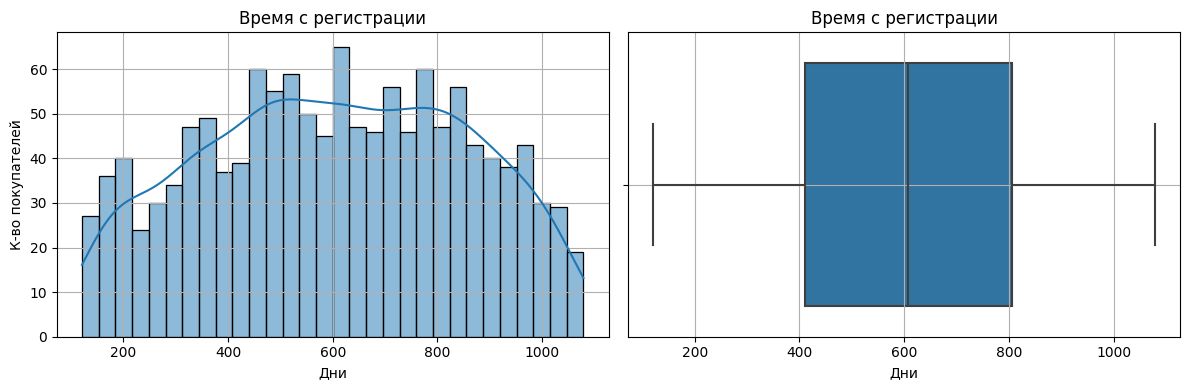

c:\Users\a.vlasova\coding\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


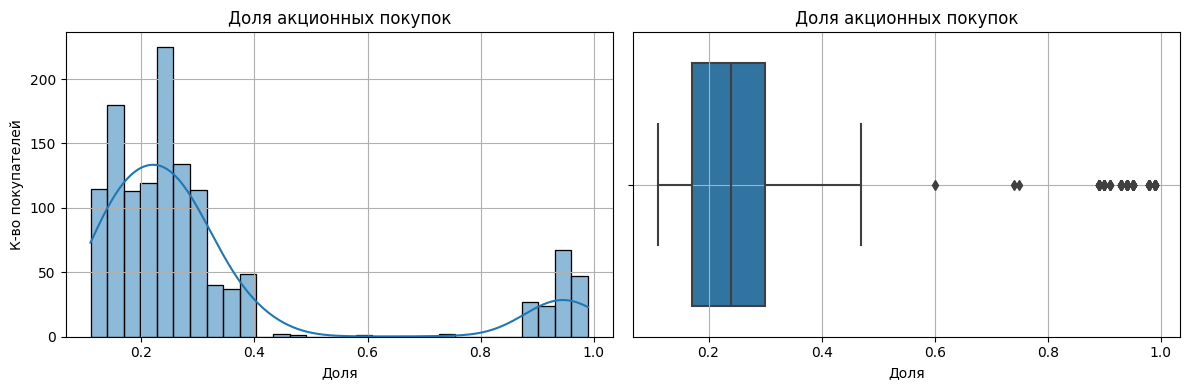

c:\Users\a.vlasova\coding\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


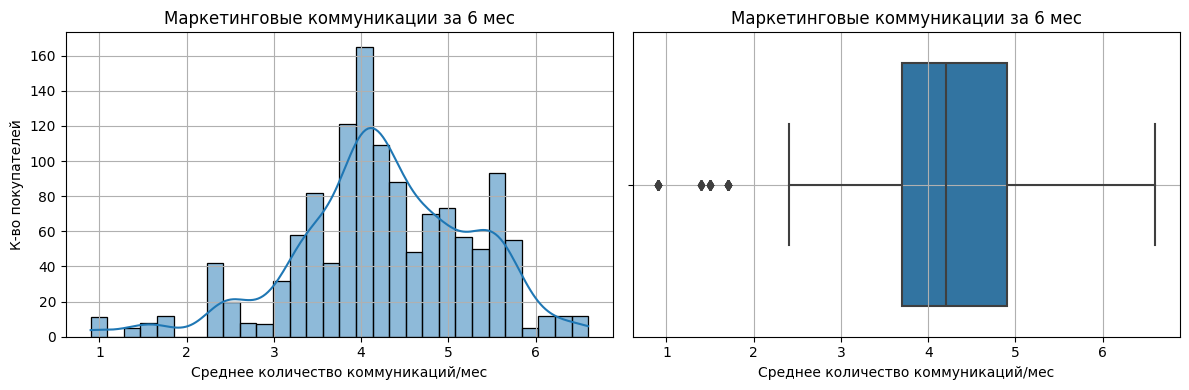

In [135]:
# 1 - Неприрывные данные
#Создаём словарь для красивых подписей

labels = {
    'длительность': ['Время с регистрации', 'Дни', 'К-во покупателей'],
    'акционные_покупки': ['Доля акционных покупок', 'Доля', 'К-во покупателей'],
    'маркет_актив_6_мес' : ['Маркетинговые коммуникации за 6 мес', 'Среднее количество коммуникаций/мес', 'К-во покупателей']
}


features = ['длительность', 'акционные_покупки', 'маркет_актив_6_мес']


for feature in features:
    plt.figure(figsize=(12, 4))
    
    # Гистограмма
    plt.subplot(1, 2, 1)
    sns.histplot(customer[feature], bins=30, kde=True)
    plt.title(labels[feature][0])
    plt.xlabel(labels[feature][1])
    plt.ylabel(labels[feature][2])
    plt.grid(True)
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=customer[feature])
    plt.title(labels[feature][0])
    plt.xlabel(labels[feature][1])
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

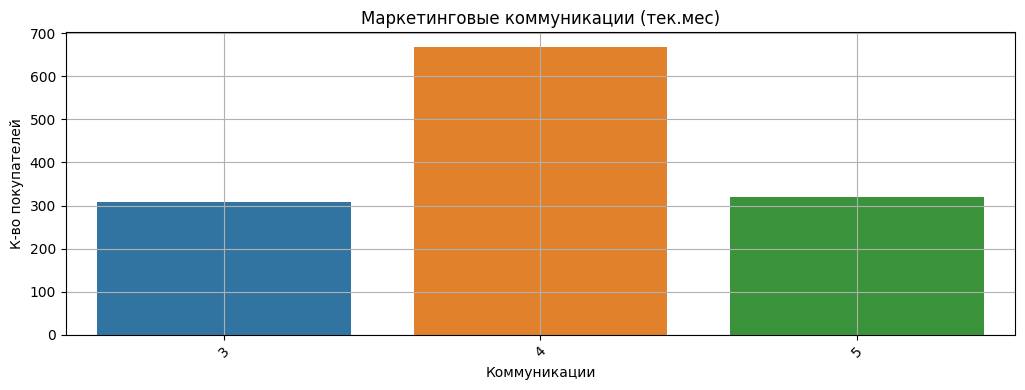

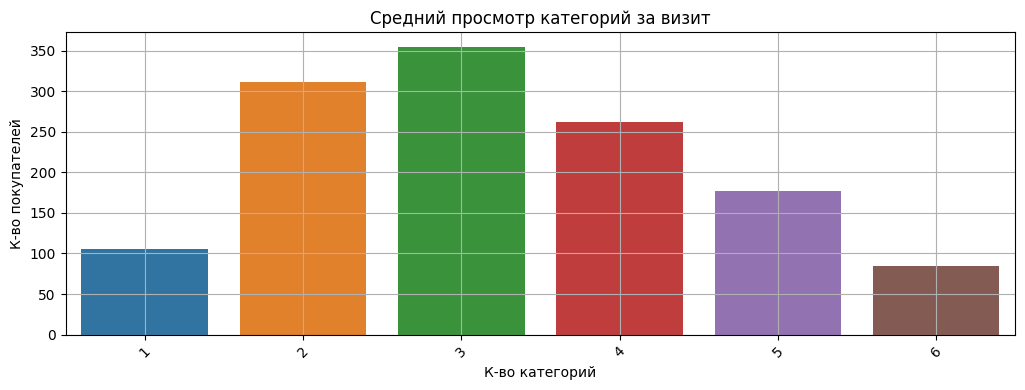

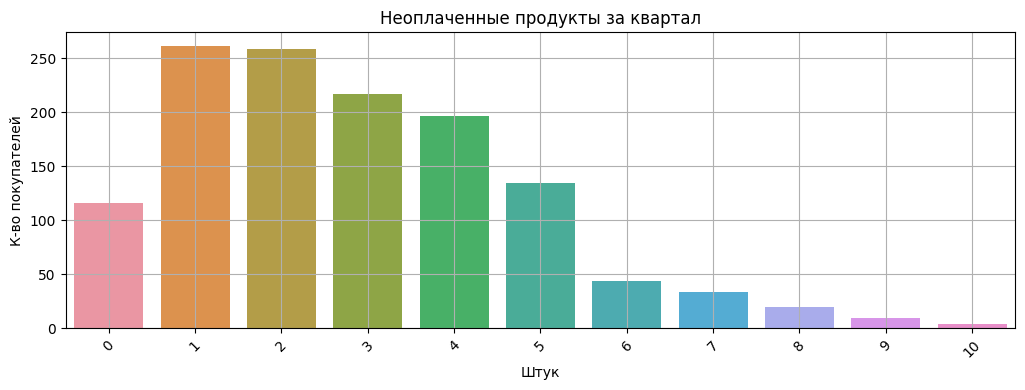

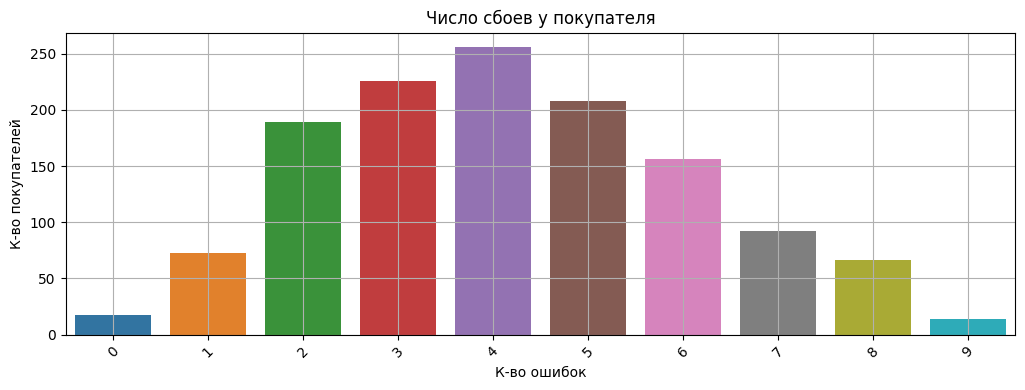

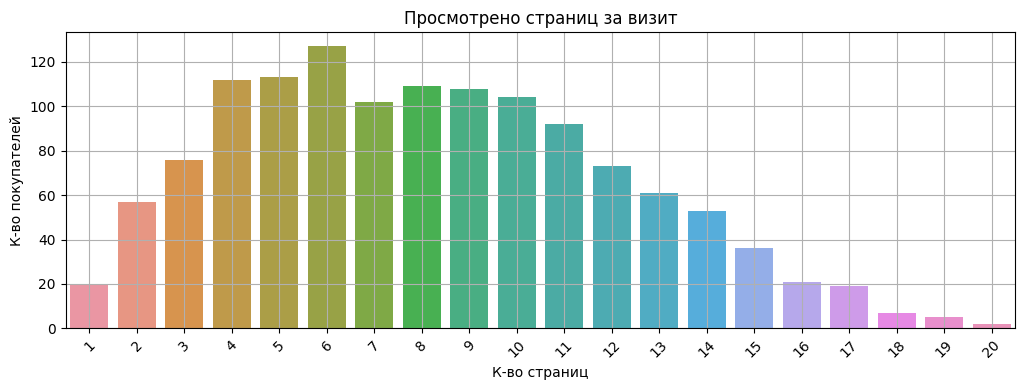

In [136]:
disc_labels_ = {
    'маркет_актив_тек_мес': ['Маркетинговые коммуникации (тек.мес)', 'Коммуникации', 'К-во покупателей'],
    'средний_просмотр_категорий_за_визит': ['Средний просмотр категорий за визит', 'К-во категорий', 'К-во покупателей'],
    'неоплаченные_продукты_штук_квартал': ['Неоплаченные продукты за квартал', 'Штук', 'К-во покупателей'],
    'ошибка_сервиса': ['Число сбоев у покупателя', 'К-во ошибок', 'К-во покупателей'],
    'страниц_за_визит': ['Просмотрено страниц за визит', 'К-во страниц', 'К-во покупателей']
}

features = ['маркет_актив_тек_мес', 
            'средний_просмотр_категорий_за_визит',
            'неоплаченные_продукты_штук_квартал',
            'ошибка_сервиса', 'страниц_за_визит']

for feature in features:
    plt.figure(figsize=(20, 4))
    
    # Countplot вместо гистограммы
    plt.subplot(1, 2, 1)
    sns.countplot(x=customer[feature])
    plt.title(disc_labels_[feature][0])
    plt.xlabel(disc_labels_[feature][1])
    plt.ylabel(disc_labels_[feature][2])
    plt.grid(True)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

In [137]:
# Тест Шапиро — Уилка
for col in customer.select_dtypes(include='number').columns:
    if col != 'id':
        stat, p = shapiro(customer[col].dropna())
        print(f" - {col}: p-value = {p:.4f} - {'Нормальное' if p > 0.05 else 'Не нормальное'}")

 - маркет_актив_6_мес: p-value = 0.0000 - Не нормальное
 - маркет_актив_тек_мес: p-value = 0.0000 - Не нормальное
 - длительность: p-value = 0.0000 - Не нормальное
 - акционные_покупки: p-value = 0.0000 - Не нормальное
 - средний_просмотр_категорий_за_визит: p-value = 0.0000 - Не нормальное
 - неоплаченные_продукты_штук_квартал: p-value = 0.0000 - Не нормальное
 - ошибка_сервиса: p-value = 0.0000 - Не нормальное
 - страниц_за_визит: p-value = 0.0000 - Не нормальное


    Ни один из числовых признаков не имеет нормального распределения.   
    
    Распределение маркетинговой активности за последние пол года смещено вправо. Пик - 4. Половина клиентов находятся в
    диапазоне 3,5–5 контактов за пол года. Есть небольшое количество выбросов с низким количеством контактов 
    (1-2 за пол года).
    Большая часть маркетинговой активности за текущий месяц равна 4 контактам.
    Длительность: распределение равномерное, представлены и новые и постоянные покупатели.
    Доля акционных покупок в среднем составляет 25%, большая лежит до 40% о чем свидетельствует смещение к левой 
    части гистограммы. Есть выброс среди клиентов, которые совершают более 90% покупок по акции (эту категорию клиентов 
    учтём при формировании групп).
    Средний просмотр категорий за визит находится в диапазоне от 1 до 6, основная часть = 3.
    Среднее количество неплаченных продуктов в квартал = 3. Гистограмма смещена в левую сторону, основная часть 
    покупателей неоплачивает в квартал <= 5 продуктов. Очень небольшое количество верхних значений.
    Число ошибок сервиса: распределение равномерное с пиком - 4 ошибки/квартал.
    Среднее количество просмотренных страниц за визит: пользователи просматривают 1-20 страниц, распределение немного 
    смещено в меньшую сторону. Чаще всего пользователи просматривают около 6 страниц за визит.
   

Рассмотрим категориальные признаки:

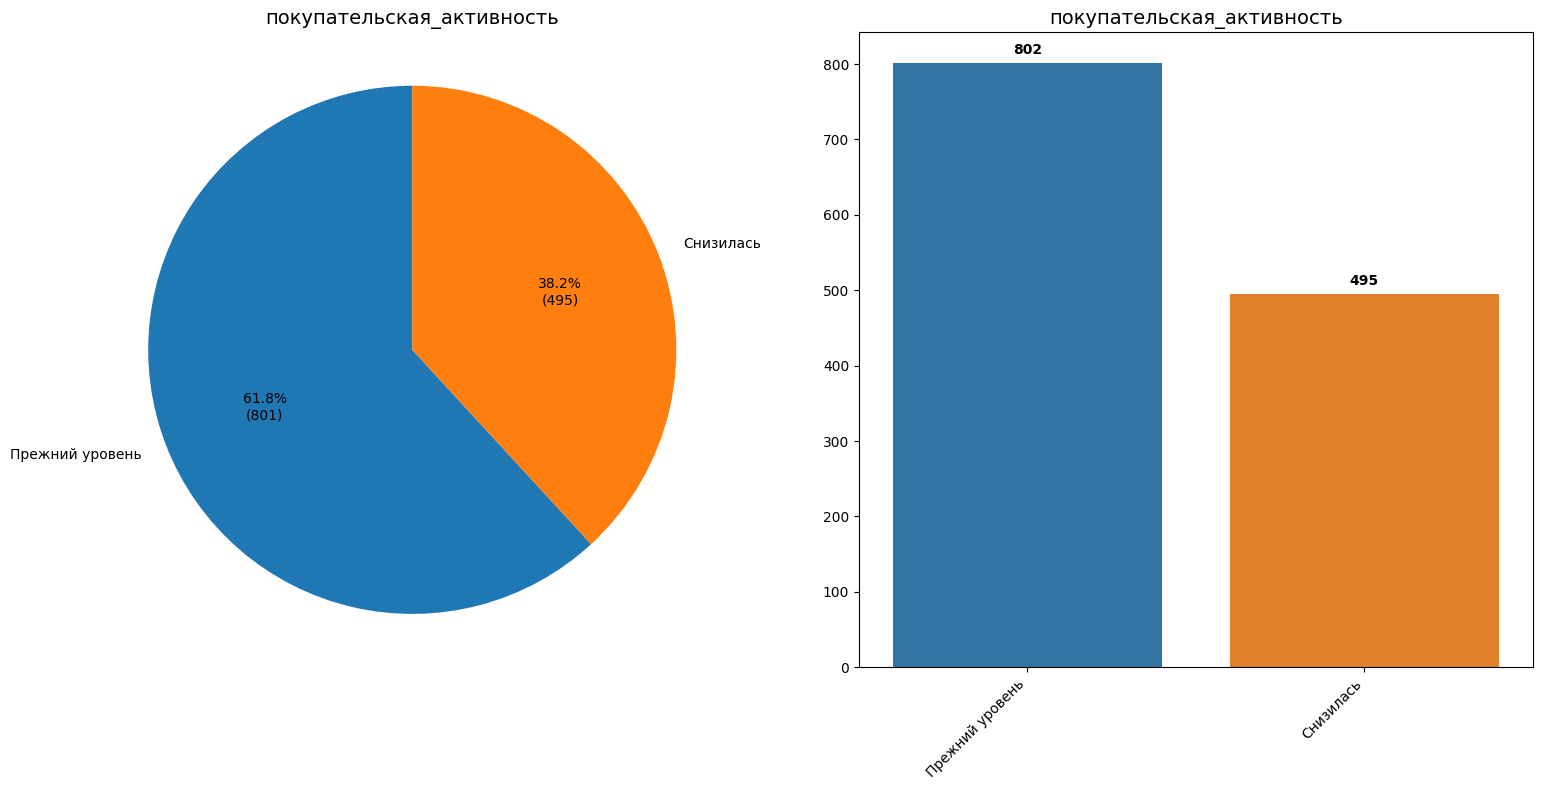

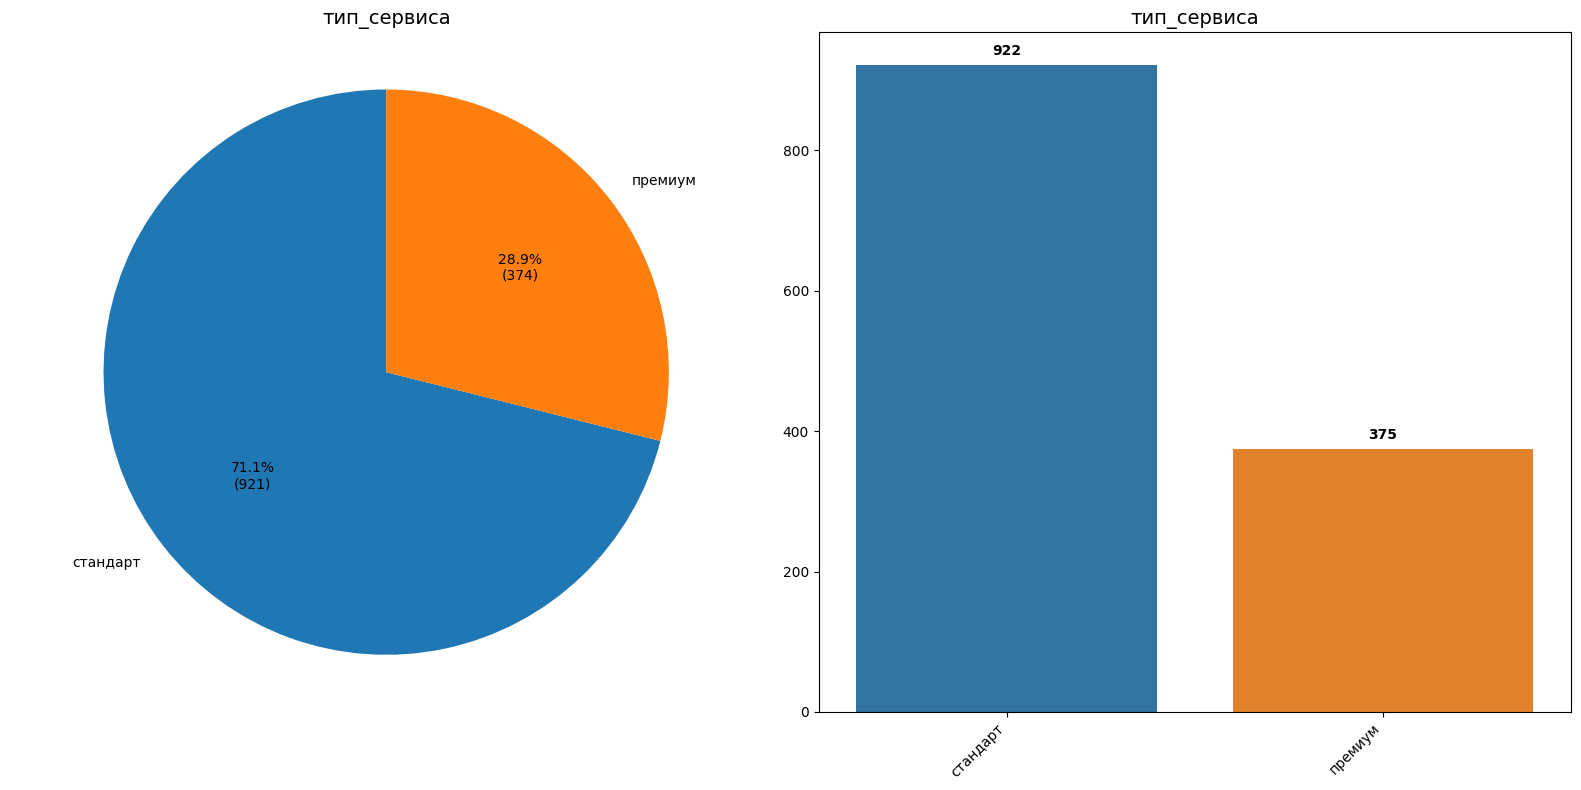

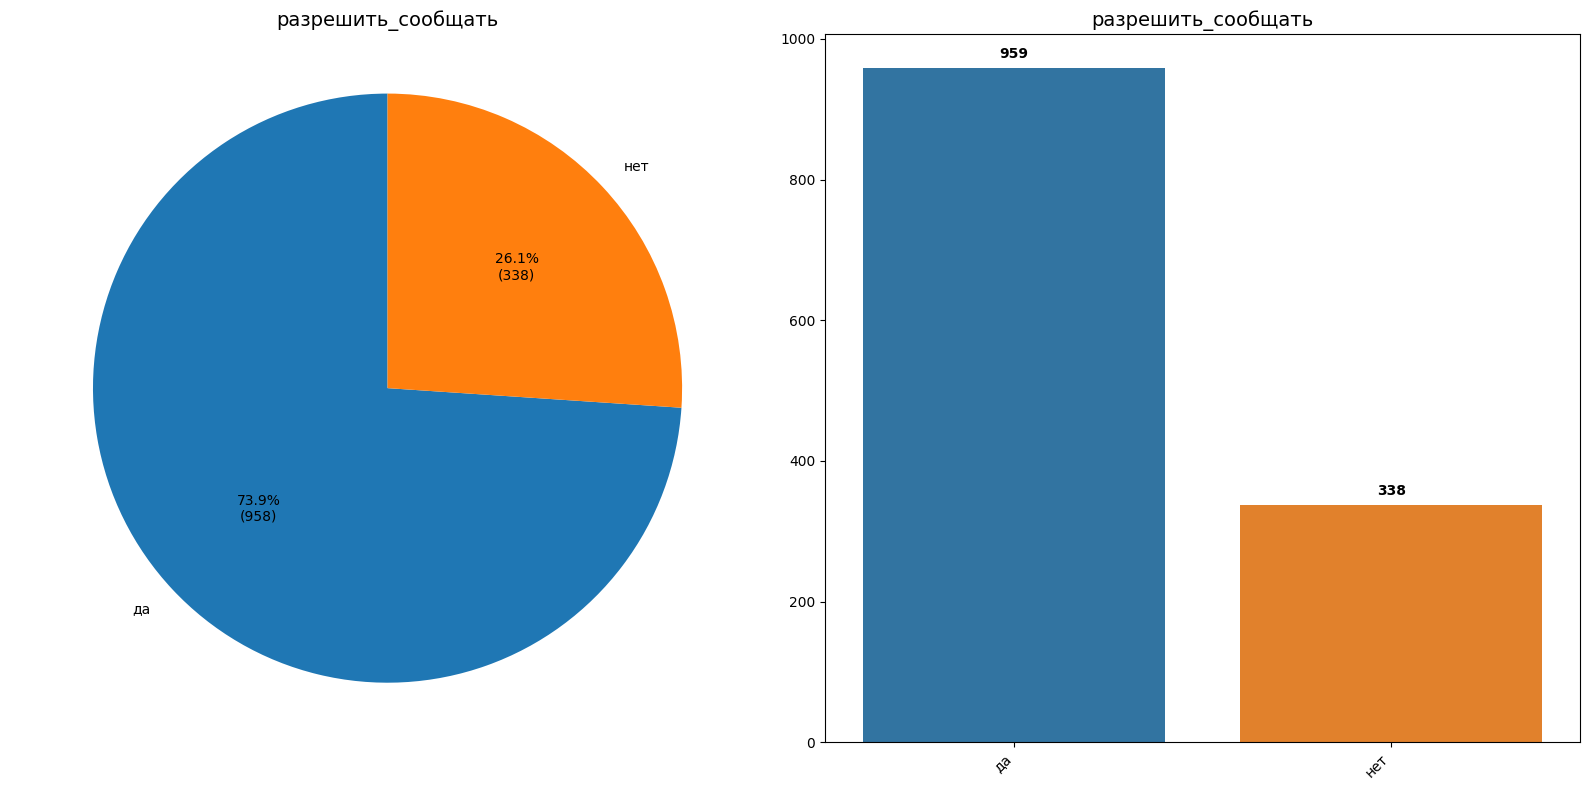

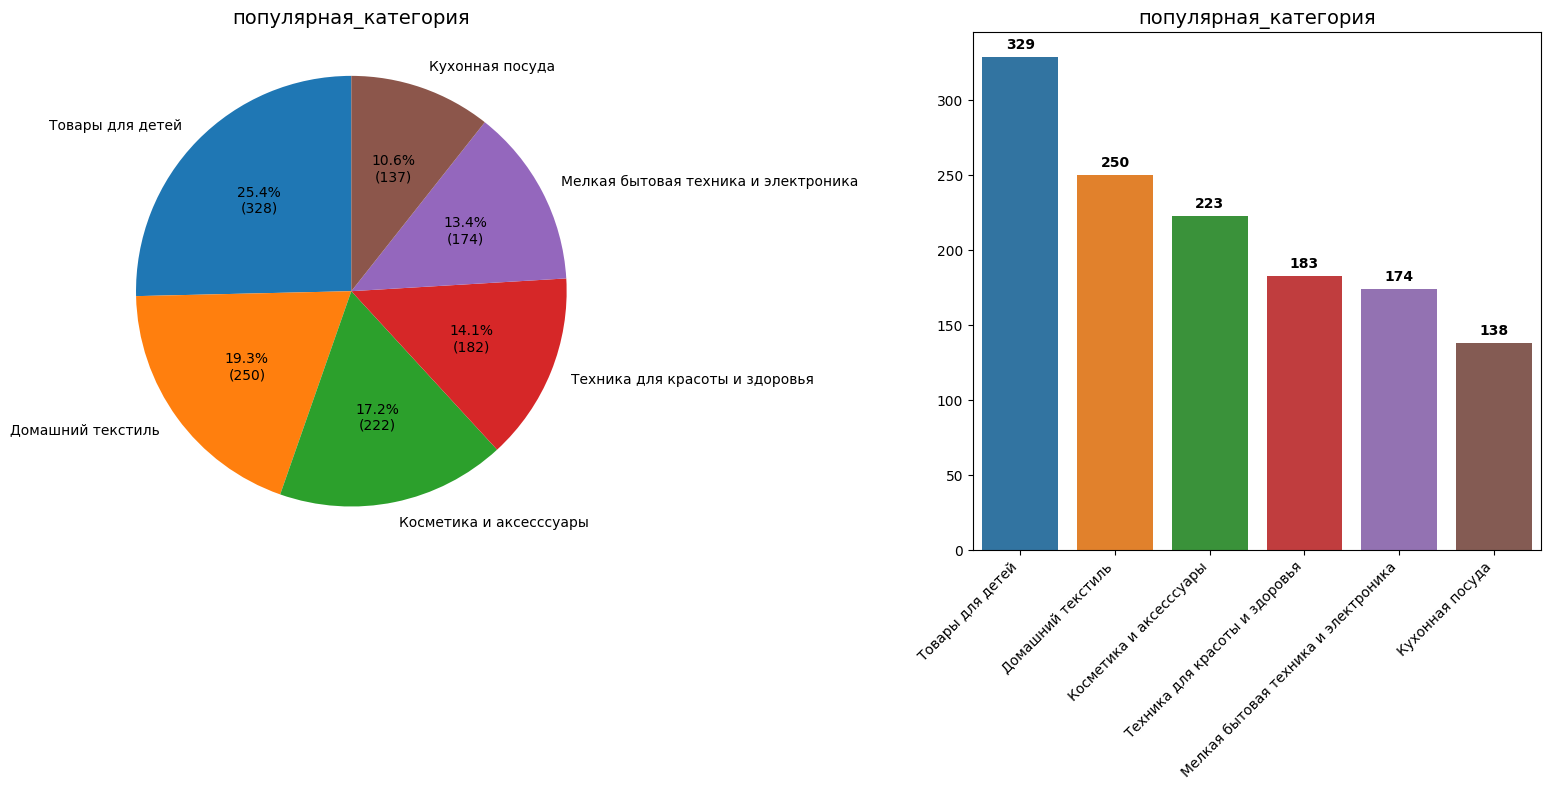

In [138]:
cat_cols = customer.select_dtypes(include=['object', 'category']).columns

for col in cat_cols:
    value_counts = customer[col].value_counts(dropna=False)


    plt.figure(figsize=(16, 8))

    # Круговая диаграмма
    plt.subplot(1, 2, 1)
    wedges, texts, autotexts = plt.pie(
    value_counts,
    labels=value_counts.index.astype(str),
    autopct=lambda p: f'{p:.1f}%\n({int(p*sum(value_counts)/100)})',
    startangle=90)
    
    plt.title(col, fontsize=14)
    plt.axis('equal')

    # Столбчатая диаграмма
    plt.subplot(1, 2, 2)
    ax = sns.barplot(x=value_counts.index.astype(str), y=value_counts.values)
    plt.title(col, fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('')
    

    for i, v in enumerate(value_counts.values):
        ax.text(i, v + 0.01 * max(value_counts.values), str(v), 
                ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    Покупательская активность снизилась у 38% пользователей.
    При этом совсем ничего не покупали в магазине только 0.2% посетителей.
    Большинство покупателей (71%) используют обычный тип сервиса, 28% используют премиум
    Большинство покупатеоей (74%) разрешают рассылки, 26% не разрешают.
    Самая популярная категория магазина - товары для детей (у 25% пользователей), популярная у наименьшего числа 
    пользователей - кухонная посуда.

**2. DF market_money**

In [139]:
market_money['выручка'].describe()

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64

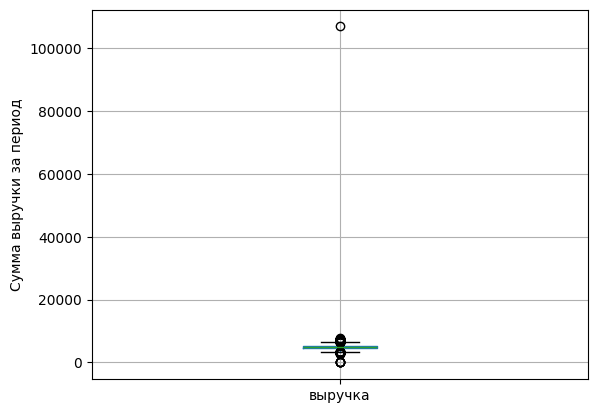

In [140]:
market_money.boxplot('выручка')
plt.ylabel('Cумма выручки за период')
plt.show()

In [141]:
market_money[market_money['выручка'] > 100000]

,id,период,выручка
98,215380,текущий_месяц,106862.2


In [142]:
market_money['выручка'].describe()

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64

Проверили выброс, тк он единственный можем его удалить.

In [143]:
market_money = market_money[market_money['выручка'] < 100000]

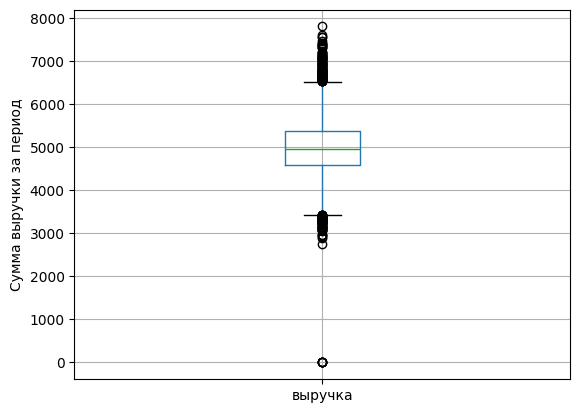

In [144]:
# Проверяем boxplot без выброса
market_money.boxplot('выручка')
plt.ylabel('Cумма выручки за период')
plt.show()

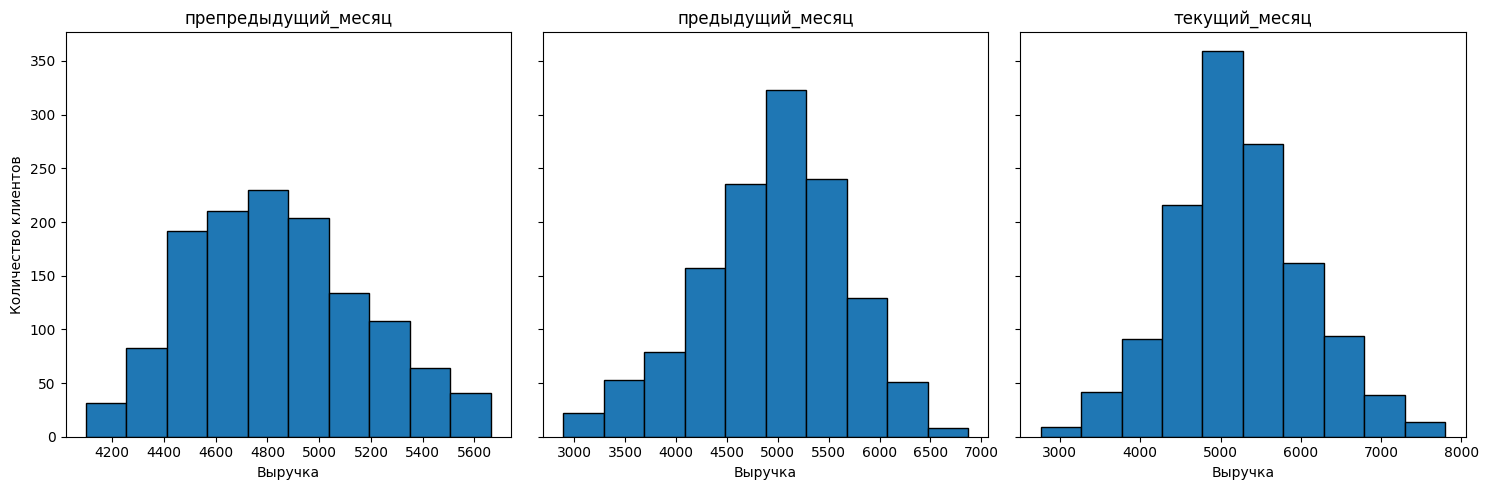

In [145]:
#Смотрим распределение выручки по периодам, учитываем только активных покупателей
periods = ['препредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц']

# Строим 3 гистограммы в одной фигуре
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, period in enumerate(periods):
    subset = market_money[(market_money['период'] == period) & (market_money['выручка'] != 0)]['выручка']
    axes[i].hist(subset, bins=10, edgecolor='black')
    axes[i].set_title(period)
    axes[i].set_xlabel('Выручка')
    if i == 0:
        axes[i].set_ylabel('Количество клиентов')

plt.tight_layout()
plt.show()

    В датафрейме market_money на протяжении трех месяцев наблюдается слабый тренд на улучшение: расширяется диапазон чеков (появляются более большие и маленькие) и увеличивается их количество.

**3. DF time**

In [146]:
time.describe().drop(columns=['id'])

,минут
count,2600.000000
mean,13.336154
std,4.080198
min,4.000000
25%,10.000000
50%,13.000000
75%,16.000000
max,23.000000


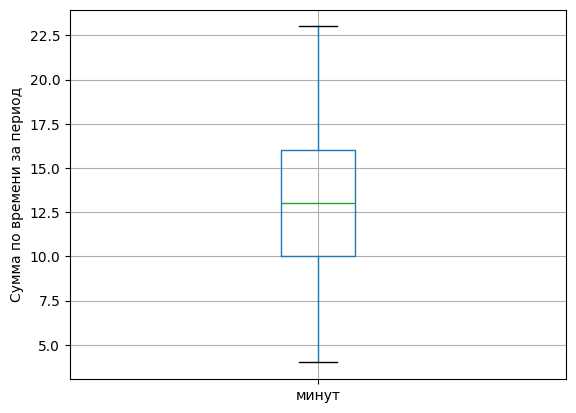

In [147]:
time.boxplot('минут')
plt.ylabel('Сумма по времени за период')
plt.show()

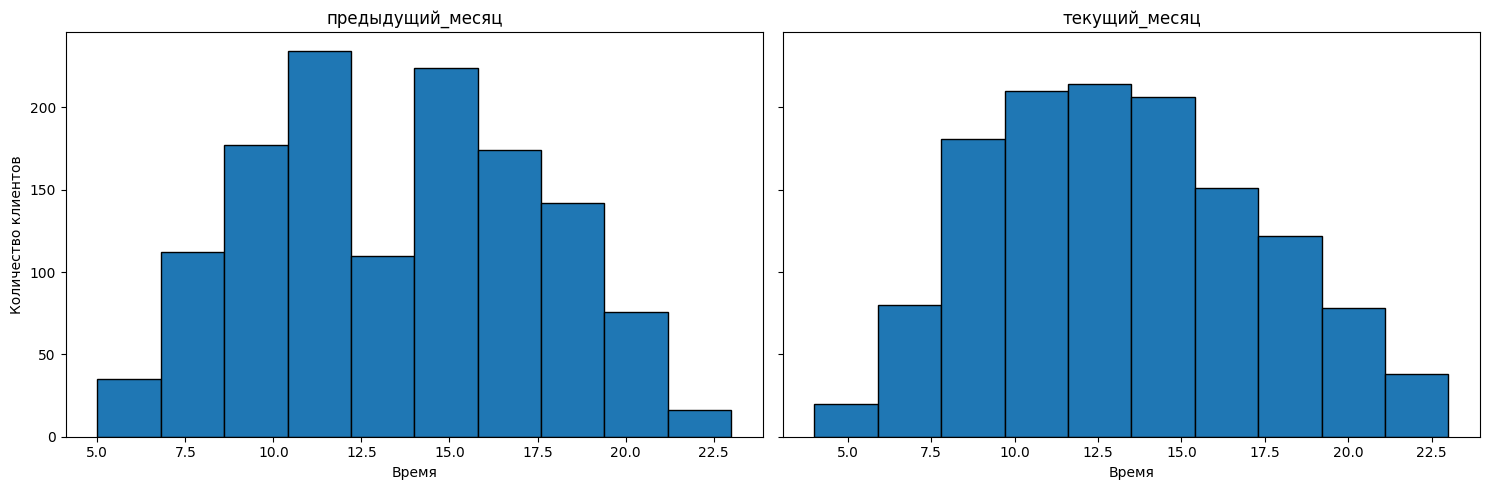

In [148]:
#Смотрим распределение по времени в минутах по периодам
periods = ['предыдущий_месяц', 'текущий_месяц']


fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

for i, period in enumerate(periods):
    subset = time[time['период'] == period]['минут']
    axes[i].hist(subset, bins=10, edgecolor='black')
    axes[i].set_title(period)
    axes[i].set_xlabel('Время')
    if i == 0:
        axes[i].set_ylabel('Количество клиентов')

plt.tight_layout()
plt.show()

    График текущего месяца больше стремится к нормальному распределению с пиком в 12.5.
    В предыдущий месяц более ярко выделялось 2 пика: 11 минут и 15 минут. 

**2. DF money**

In [149]:
money['прибыль'].describe()

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

Максимальная выручка по покупателю из датафрейма market_money = 7799 рубля, поэтому максимальная прибыль указана как 7.4 условных единицы. Вероятнее всего нужно вернуть значения к тысячам.

Text(0, 0.5, 'Количество пользователей')

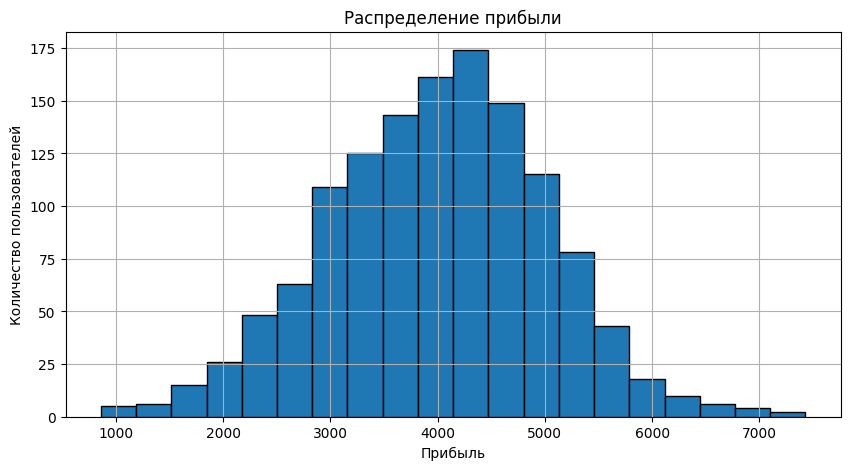

In [150]:
money['прибыль'] *= 1000

money['прибыль'].hist(figsize=(10, 5), bins=20, edgecolor='black')
plt.title('Распределение прибыли')
plt.xlabel('Прибыль')
plt.ylabel('Количество пользователей')

**Вывод:**

    На этом этапе был удалён выброс в df market_money - завышенный показатель выручки.
    Показатель прибыли в df money был нормализован.
    Был выявлен дисбаланс классов в переменных, который нужно будет учесть при дальнейшей работе с моделью 
    (видно на графиках категориальных переменных).
    
    В df costumer был добавлен категориальный признак, указывающий была ли у клиента покупательская активность в течение 
    3х последних месяцев или нет.

# Шаг 4. Объединение таблиц

In [151]:
market_money_wide = market_money.pivot_table(index='id', columns='период', values='выручка', aggfunc='first').reset_index()
market_money_wide.columns = ['id'] + [f'выручка_{col}' for col in market_money_wide.columns if col != 'id']

time_wide = time.pivot_table(index='id', columns='период', values='минут', aggfunc='first').reset_index()
time_wide.columns = ['id'] + [f'время_{col}' for col in time_wide.columns if col != 'id']

total = customer.merge(market_money_wide, on='id', how='left').merge(time_wide, on='id', how='left')

In [152]:
for col in total.select_dtypes(include=['object']).columns:
    total[col] = total[col].str.lower()

In [153]:
quick_check(total)

Размер датасета: (1297, 18)

Описание датасета:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   покупательская_активность            1297 non-null   object 
 2   тип_сервиса                          1297 non-null   object 
 3   разрешить_сообщать                   1297 non-null   object 
 4   маркет_актив_6_мес                   1297 non-null   float64
 5   маркет_актив_тек_мес                 1297 non-null   int64  
 6   длительность                         1297 non-null   int64  
 7   акционные_покупки                    1297 non-null   float64
 8   популярная_категория                 1297 non-null   object 
 9   средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1297 non-nu

None


Вывод первых строк:


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц
0,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10



Пропущенные значения:


id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
выручка_предыдущий_месяц               0
выручка_препредыдущий_месяц            0
выручка_текущий_месяц                  1
время_предыдущий_месяц                 0
время_текущий_месяц                    0
dtype: int64


Уникальные значения:


id                                     1297
покупательская_активность                 2
тип_сервиса                               2
разрешить_сообщать                        2
маркет_актив_6_мес                       41
маркет_актив_тек_мес                      3
длительность                            657
акционные_покупки                        41
популярная_категория                      6
средний_просмотр_категорий_за_визит       6
неоплаченные_продукты_штук_квартал       11
ошибка_сервиса                           10
страниц_за_визит                         20
выручка_предыдущий_месяц               1121
выручка_препредыдущий_месяц             789
выручка_текущий_месяц                  1238
время_предыдущий_месяц                   19
время_текущий_месяц                      20
dtype: int64


Дубликаты датасета:


0

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц



Неявные дубликаты категориальных значений:
покупательская_активность: ['снизилась' 'прежний уровень']
тип_сервиса: ['премиум' 'стандарт']
разрешить_сообщать: ['да' 'нет']
популярная_категория: ['товары для детей' 'домашний текстиль' 'косметика и аксесccуары'
 'кухонная посуда' 'техника для красоты и здоровья'
 'мелкая бытовая техника и электроника']


In [154]:
#Удаляем единственный пропуск по выручке за текущий месяц
total = total.dropna()
total.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
выручка_предыдущий_месяц               0
выручка_препредыдущий_месяц            0
выручка_текущий_месяц                  0
время_предыдущий_месяц                 0
время_текущий_месяц                    0
dtype: int64

**Вывод:**

В этом шаге объединили три датасета customer, market_money, time с помощью id клиентов. Периоды перенесены в отдельные столбцы. Ошибок после объединения не обнаружено.

# Шаг 5. Корреляционный анализ

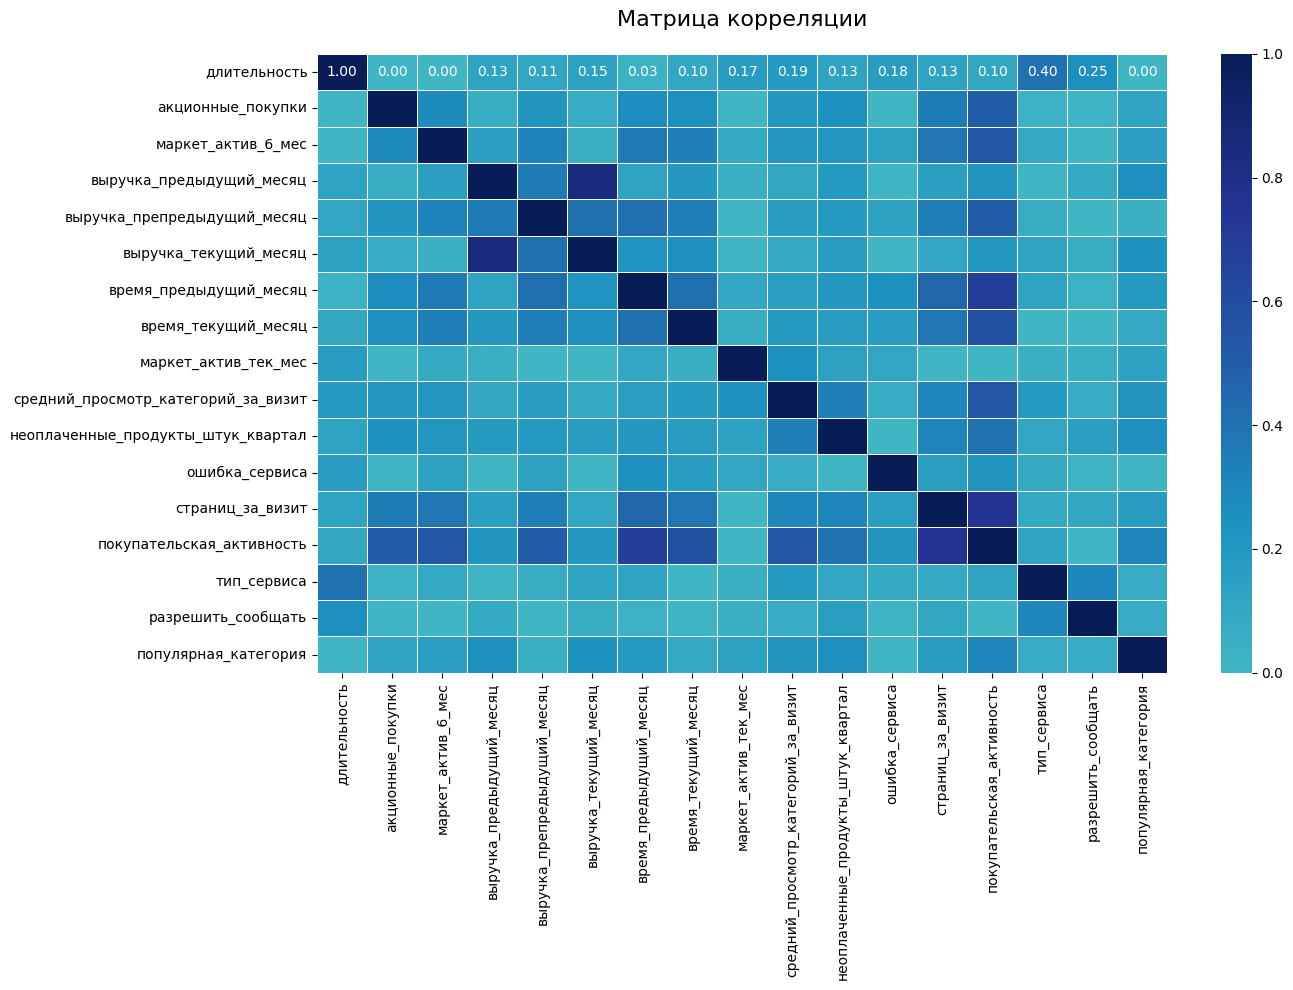

In [155]:
plt.figure(figsize=(14, 10))


num_cols = [
    'длительность', 
    'акционные_покупки', 
    'маркет_актив_6_мес', 
    'выручка_предыдущий_месяц', 
    'выручка_препредыдущий_месяц', 
    'выручка_текущий_месяц',
    'время_предыдущий_месяц', 
    'время_текущий_месяц'
]

discr_cols = [
    'маркет_актив_тек_мес', 
    'средний_просмотр_категорий_за_визит', 
    'неоплаченные_продукты_штук_квартал', 
    'ошибка_сервиса', 
    'страниц_за_визит'
]

cat_cols = [
    'покупательская_активность', 
    'тип_сервиса', 
    'разрешить_сообщать', 
    'популярная_категория'
]



all_cols = num_cols + discr_cols + cat_cols
corr_matrix = total[all_cols].phik_matrix(interval_cols=num_cols)


sns.heatmap(
    corr_matrix,
    annot=True, 
    fmt='.2f',
    cmap='YlGnBu',
    linewidths=0.5,
    center=0
)

plt.title('Матрица корреляции', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

**Целевой признак**
    
- Сильно коррелирует с: маркетинговая активность 6 мес, акционные покупки, средний просмотр категорий за визит, неоплаченные продукты за квартал, страницу за визит, выручка предыдущий месяц, время за текущий и предыдущий месяц.
- Нулевая корреляция: разрешение получать сообщения
    
    Удалим из датасета признаки, которые меньше всего описывают ЦП - с нулевым и низким показателем корреляции.
    Также удалим утечки: время и выручка за текущий месяц.
    
    
Видим значительную корреляцию показателей:
    
- выручка_предыдущий_месяц и выручка_позапрошлый_месяц
- выручка_текущий_месяц и выручка_предыдущий_месяц
- выручка_текущий_месяц и выручка_позапрошлый_месяц

    Таккже выделим более слабую, но значительную корреляцию между следующими признаками:
- **Акционные покупки связаны** с время_текущий_месяц, страниц за визит и маркетинговая активность за 6 мес (отрицательная зависимость), 
- **Страниц за визит коррелирует** с время предыдущий месяц, время текущий месяц, маркетинговая активность за 6 мес, средний просмотр категорий за визит, выручка предыдущий месяц.
- **Время_предыдущий месяц** коррелирует с время_текущий месяц, выручка препредыдущий месяц, страниц за визит, маркетинговая активность 6 мес.


    Обратим также внимание, что ошибка сервиса влияет коррелирует с временем, проведённым на сайте, однако это время 
    не является положительным, удерживающим клиента опытом. При этом ошибка сервиса слабо коррелирует с неоплаченными 
    покупками, значит проблема не в возможности оплатить.
    
    С длительностью пребывания на сайте также взаимосвязан тип сервиса
    
    Была обнаружена корреляция большого количества акционных покупок и неоплаченных товаров в корзине. Возможно, эти
    пользователи заранее откладывают интересующие товары и оплачивают из только когда есть акции. 

In [156]:
# Удаляем лишние столбцы
clean_total = total.drop([
    'разрешить_сообщать',
    'выручка_текущий_месяц',
    'время_текущий_месяц'
], axis=1)

#Создаём новый агрегированный признак на основе выручки за последние 2 месяца, исключая текущий
clean_total['средняя_выручка_2мес'] = (
    clean_total['выручка_предыдущий_месяц'] + clean_total['выручка_препредыдущий_месяц']
) / 2

clean_total = clean_total.drop([
    'выручка_предыдущий_месяц',
    'выручка_препредыдущий_месяц'
], axis=1)

clean_total.head()

,id,покупательская_активность,тип_сервиса,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,время_предыдущий_месяц,средняя_выручка_2мес
0,215349,снизилась,премиум,4.4,4,819,0.75,товары для детей,4,4,2,5,12,4844.00
1,215350,снизилась,стандарт,4.9,3,539,0.14,домашний текстиль,5,2,1,5,8,5141.75
2,215351,снизилась,стандарт,3.2,5,896,0.99,товары для детей,5,0,6,4,11,5475.50
3,215352,снизилась,стандарт,5.1,3,1064,0.94,товары для детей,3,2,3,2,8,5200.75
4,215353,снизилась,стандарт,3.3,4,762,0.26,домашний текстиль,4,1,1,4,10,4931.25


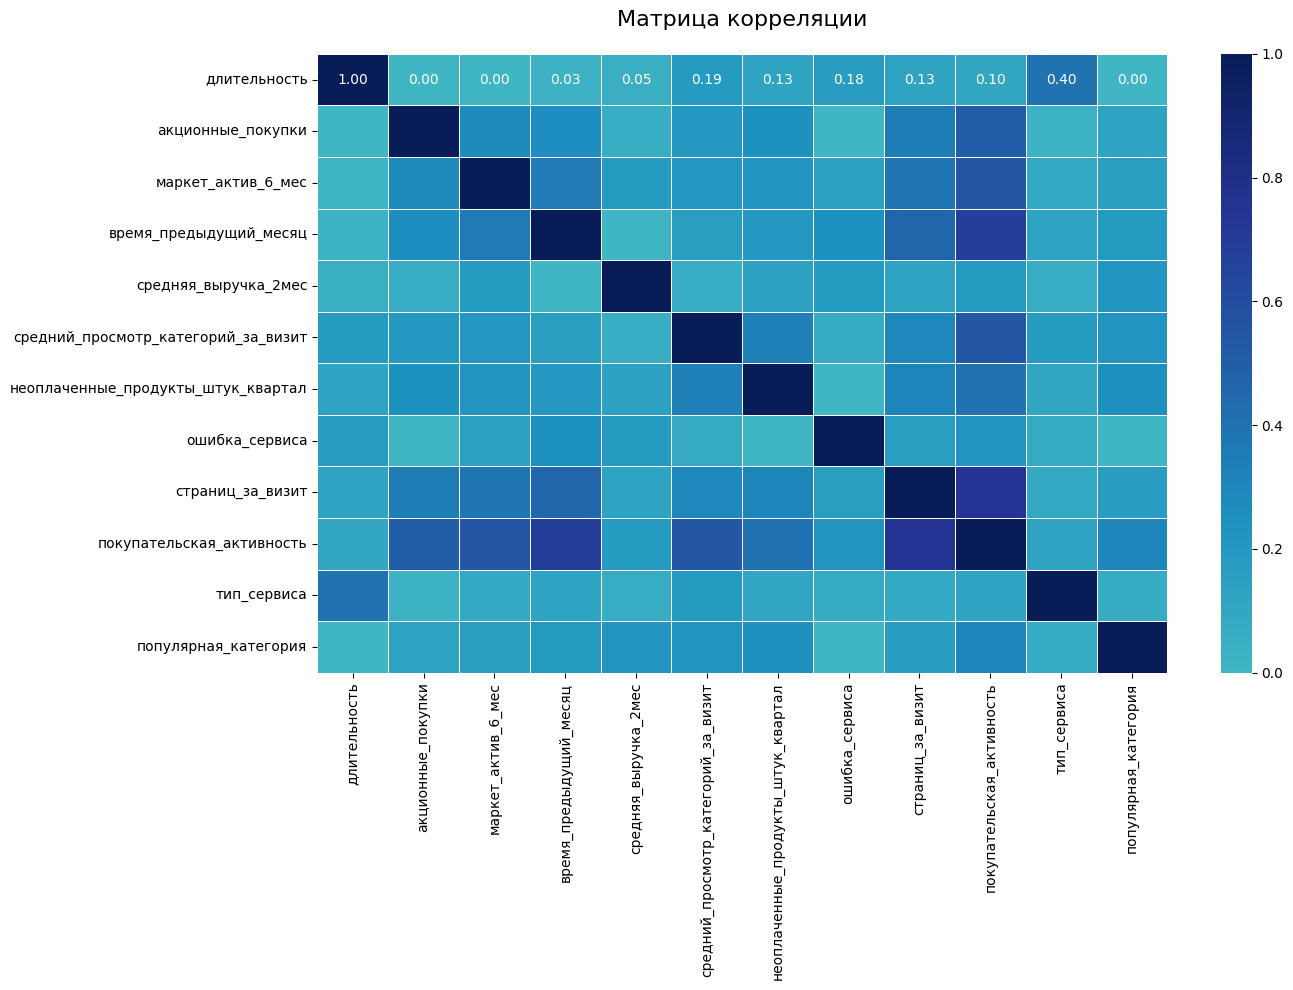

In [157]:
plt.figure(figsize=(14, 10))


num_cols = [
    'длительность', 
    'акционные_покупки', 
    'маркет_актив_6_мес', 
    'время_предыдущий_месяц', 
    'средняя_выручка_2мес'
]

discr_cols = [ 
    'средний_просмотр_категорий_за_визит', 
    'неоплаченные_продукты_штук_квартал', 
    'ошибка_сервиса', 
    'страниц_за_визит'
]

cat_cols = [
    'покупательская_активность', 
    'тип_сервиса',  
    'популярная_категория'
]



all_cols = num_cols + discr_cols + cat_cols
corr_matrix = clean_total[all_cols].phik_matrix(interval_cols=num_cols)


sns.heatmap(
    corr_matrix,
    annot=True, 
    fmt='.2f',
    cmap='YlGnBu',
    linewidths=0.5,
    center=0
)

plt.title('Матрица корреляции', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))

numeric_columns = clean_total.drop('id', axis=1).select_dtypes(include=['number']).columns.tolist()

sns.heatmap(
    clean_total.drop('id', axis=1).phik_matrix(interval_cols=numeric_columns), 
    annot=True, 
    fmt='.2f',
    cmap='YlGnBu',
    linewidths=0.5,
    center=0
)

plt.title('Матрица корреляции', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

**Вывод:**

    На этапе корреляционного анализа были удалены признаки с нулевой или слабой корреляцией с ЦП.
    Так как мы будем строить модель которая предсказывает поведение потребителей удалили утечки: выручка_текущий_месяц и время_текущий_месяц.
    Был создан аггрегированный столбец со средней выручкой за последние 2 месяца (не включая текущий).

# Шаг 6. Использование пайплайнов

In [158]:
#Разделение
X = clean_total.drop(['id', 'покупательская_активность'], axis=1)
y = clean_total['покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)

In [159]:
#Проверяем размеры выборок
print("Размеры выборок:")
print(f"X_train: {X_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test:  {y_test.shape}")
print(f"Общее количество наблюдений: {len(clean_total)}")
print(f"Количество признаков: {X.shape[1]}")
print(f"Размер тестовой выборки: {TEST_SIZE * 100}%")


print(f"\nПропорции целевой переменной:")
print("Train:", y_train.value_counts(normalize=True))
print("Test: ", y_test.value_counts(normalize=True))

Размеры выборок:
X_train: (972, 12)
X_test:  (324, 12)
y_train: (972,)
y_test:  (324,)
Общее количество наблюдений: 1296
Количество признаков: 12
Размер тестовой выборки: 25.0%

Пропорции целевой переменной:
Train: покупательская_активность
прежний уровень    0.618313
снизилась          0.381687
Name: proportion, dtype: float64
Test:  покупательская_активность
прежний уровень    0.62037
снизилась          0.37963
Name: proportion, dtype: float64


In [160]:
ord_cols = ['тип_сервиса']
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.difference(ord_cols)
num_cols = X_train.select_dtypes(include=['number']).columns


cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(
        handle_unknown='ignore', 
        sparse_output=False, 
        drop='first'
    ))
])

ord_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=[['стандарт', 'премиум']], handle_unknown='use_encoded_value', unknown_value=-1))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_cols),
    ('ord', ord_pipe, ord_cols),
    ('num', num_pipe, num_cols)
])

final_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=6))
])

final_pipe.fit(X_train, y_train)

y_pred = final_pipe.predict_proba(X_test)
score = roc_auc_score(y_test, y_pred[:, 1])
print(f'Test ROC-AUC: {score:.4f}')

Test ROC-AUC: 0.8412


In [161]:
# Logistic Regression
logreg_params = {
    'preprocessor__cat__encoder': [
        OneHotEncoder(drop='first'),
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    ],
    'preprocessor__ord__encoder': [
        OrdinalEncoder(categories=[['стандарт', 'премиум']], handle_unknown='use_encoded_value', unknown_value=-1)
    ],
    'preprocessor__num__scaler': [
        StandardScaler(),
        MinMaxScaler(),
        RobustScaler()
    ],
    'classifier': [
        LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            max_iter=2000
        )
    ],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2', 'elasticnet'],
    'classifier__l1_ratio': [0.1, 0.5, 0.9]
}


# K Nearest Neighbors
knn_params = {
    'preprocessor__cat__encoder': [
        OneHotEncoder(drop='first'),
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    ],
    'preprocessor__ord__encoder': [
        OrdinalEncoder(categories=[['стандарт', 'премиум']], handle_unknown='use_encoded_value', unknown_value=-1)
    ],
    'preprocessor__num__scaler': [
        StandardScaler(),
        MinMaxScaler(),
        RobustScaler()
    ],
    'classifier': [
        KNeighborsClassifier()
    ],
    'classifier__n_neighbors': [1, 3, 5, 7, 9, 11, 15, 20, 25],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
}


# Decision Tree
tree_params = {
    'preprocessor__cat__encoder': [
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        OneHotEncoder(drop='first')
    ],
    'preprocessor__ord__encoder': [
        OrdinalEncoder(categories=[['стандарт', 'премиум']], handle_unknown='use_encoded_value', unknown_value=-1)
    ],
    'preprocessor__num__scaler': [
        StandardScaler(),
        MinMaxScaler(),
        RobustScaler()
    ],
    'classifier': [
        DecisionTreeClassifier(random_state=RANDOM_STATE)
    ],
    'classifier__max_depth': [None, 5, 10, 15, 20, 25, 30],
    'classifier__min_samples_leaf': [1, 2, 5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10, 15, 20],
    'classifier__criterion': ['gini', 'entropy', 'log_loss']
}


# Support Vector Classifier
svc_params = {
    'preprocessor__cat__encoder': [
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        OneHotEncoder(drop='first')
    ],
    'preprocessor__ord__encoder': [
        OrdinalEncoder(categories=[['стандарт', 'премиум']], handle_unknown='use_encoded_value', unknown_value=-1)
    ],
    'preprocessor__num__scaler': [
        StandardScaler(),
        MinMaxScaler(),
        RobustScaler()
    ],
    'classifier': [
        SVC(probability=True, random_state=RANDOM_STATE)
    ],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'classifier__gamma': ['scale', 'auto', 0.1, 1, 10]
}


param_grid = [logreg_params, knn_params, tree_params, svc_params]

In [162]:
# Logistic Regression
logreg_params = {
    'preprocessor__cat__encoder': [
        OneHotEncoder(drop='first')
    ],
    'preprocessor__ord__encoder': [
        OrdinalEncoder(categories=[['стандарт', 'премиум']], handle_unknown='use_encoded_value', unknown_value=-1)
    ],
    'preprocessor__num__scaler': [
        StandardScaler(),
        MinMaxScaler(),
        RobustScaler()
    ],
    'classifier': [
        LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            max_iter=1000
        )
    ],
    'classifier__C': list(range(1, 5)),
    'classifier__penalty': ['l1', 'l2']
}


# K Nearest Neighbors
knn_params = {
    'preprocessor__cat__encoder': [
        OneHotEncoder(drop='first')
    ],
    'preprocessor__ord__encoder': [
        OrdinalEncoder(categories=[['стандарт', 'премиум']], handle_unknown='use_encoded_value', unknown_value=-1)
    ],
    'preprocessor__num__scaler': [
        StandardScaler(),
        MinMaxScaler(),
        RobustScaler()
    ],
    'classifier': [
        KNeighborsClassifier()
    ],
    'classifier__n_neighbors': [2, 5, 10, 25, 50]
}


# Decision Tree
tree_params = {
    'preprocessor__cat__encoder': [
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        OneHotEncoder(drop='first')
    ],
    'preprocessor__ord__encoder': [
        OrdinalEncoder(categories=[['стандарт', 'премиум']], handle_unknown='use_encoded_value', unknown_value=-1)
    ],
    'preprocessor__num__scaler': [
        StandardScaler(),
        MinMaxScaler(),
        RobustScaler()
    ],
    'classifier': [
        DecisionTreeClassifier(random_state=RANDOM_STATE)
    ],
    'classifier__max_depth': list(range(2, 11)),
    'classifier__min_samples_leaf': list(range(2, 10)),
    'classifier__min_samples_split': list(range(2, 10))
}


# Support Vector Classifier
svc_params = {
    'preprocessor__cat__encoder': [
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        OneHotEncoder(drop='first')
    ],
    'preprocessor__ord__encoder': [
        OrdinalEncoder(categories=[['стандарт', 'премиум']], handle_unknown='use_encoded_value', unknown_value=-1)
    ],
    'preprocessor__num__scaler': [
        StandardScaler(),
        MinMaxScaler(),
        RobustScaler()
    ],
    'classifier': [
        SVC(probability=True, random_state=RANDOM_STATE)
    ],
    'classifier__C': [10**i for i in range(-2, 3)]
}


param_grid = [logreg_params, knn_params, tree_params, svc_params]

In [163]:
grid = GridSearchCV(
    estimator=final_pipe,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"[{'classifier': [LogisticRegre...r='liblinear')], 'classifier__C': [1, 2, ...], 'classifier__penalty': ['l1', 'l2'], 'preprocessor__cat__encoder': [OneHotEncoder(drop='first')], ...}, {'classifier': [KNeighborsClassifier()], 'classifier__n_neighbors': [2, 5, ...], 'preprocessor__cat__encoder': [OneHotEncoder(drop='first')], 'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), ...], ...}, ...]"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...), ('ord', ...), ...]"


In [164]:
#Сосмотрим датафрейм с результатами моделей
results_df = pd.DataFrame(grid.cv_results_)

results_df[
    ['rank_test_score', 'mean_test_score', 'std_test_score', 'params']
].sort_values('rank_test_score').head(10)

,rank_test_score,mean_test_score,std_test_score,params
3507,1,0.906625,0.019971,"{'classifier': SVC(probability=True, random_st..."
3495,2,0.903508,0.025050,"{'classifier': SVC(probability=True, random_st..."
3501,3,0.903021,0.023755,"{'classifier': SVC(probability=True, random_st..."
3509,4,0.903005,0.030173,"{'classifier': SVC(probability=True, random_st..."
3510,5,0.901083,0.013964,"{'classifier': SVC(probability=True, random_st..."
3512,6,0.900181,0.021068,"{'classifier': SVC(probability=True, random_st..."
3504,7,0.900157,0.015281,"{'classifier': SVC(probability=True, random_st..."
3498,8,0.899502,0.016169,"{'classifier': SVC(probability=True, random_st..."
3513,9,0.897956,0.020457,"{'classifier': SVC(probability=True, random_st..."
3508,10,0.896746,0.023582,"{'classifier': SVC(probability=True, random_st..."


Лучшая модель - SVC.

In [165]:
print('Лучшая модель и параметры:', grid.best_estimator_)

Лучшая модель и параметры: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  Index(['популярная_категория'], dtype='object')),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                    

In [166]:
print('Лучший ROC-AUC:', grid.best_score_)

Лучший ROC-AUC: 0.9066254113617749


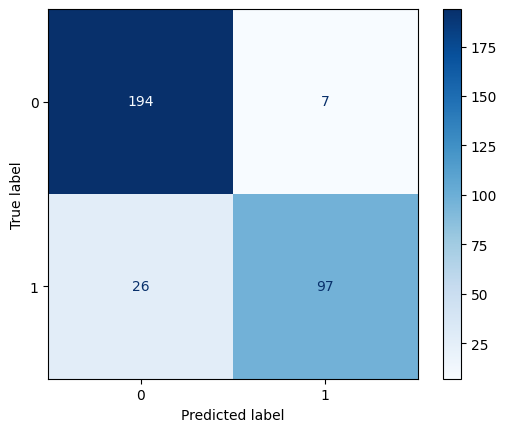

In [167]:
y_pred = grid.best_estimator_.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')

    TP = 193
    FP = 8
    TN = 97
    FN = 27
    Модель хорошо предсказывает класс 0 (активность не снизится), но может не заметить клиентов у которых может снизиться активность.
    Как отрегулировать модель будет зависеть от того, что важнее: не пропустить ни одного уходящего клиента или не потратить зря средства на акции по удержанию.

**Вывод:**

    Для оценки модели выбрали метрику roc-auc тк она подходит для работы с несбалансированными классами.
    В нашем случае активность которая "снизилась" заметно ниже чем "осталась на том же уровне", а компания 
    зря потратит средства при ошибке обоих типов: как на попытку удержания не собиравшегося уходить клиента, так и на 
    потерю постоянного покупателя.
    
    Лучшая модель - SVM с ядром RBF (C=1, probability=True)
    Метрика roc-auc = 0.901
    В целом, модель показывает хороший рузультат, но больше ошибается в опрелелении покупателей у которых снизится 
    активность.
    Регулирование модели будет зависеть от того, что выгоднее: не пропустить ни одного уходящего клиента или не потратить 
    зря средства на акции по удержанию.

# Анализ важности признаков

Нам нужно проанализировать важность признаков с помощью SHAP. Поскольку она лучше работает с линейными моделями и их легче интерпретировать - для анализа используем модель линейной регрессии.

In [168]:
best_model = grid.best_estimator_
linear_model = best_model.named_steps['classifier']


feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
X_train_prep = best_model.named_steps['preprocessor'].fit_transform(X_train)
X_test_prep  = best_model.named_steps['preprocessor'].transform(X_test)

# SHAP
explainer = shap.Explainer(linear_model.predict_proba, X_train_prep)
shap_values = explainer(X_test_prep)

PermutationExplainer explainer: 325it [06:36,  1.25s/it]                         


C:\Users\a.vlasova\AppData\Local\Temp\ipykernel_25160\2475783660.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 1], X_test_prep,


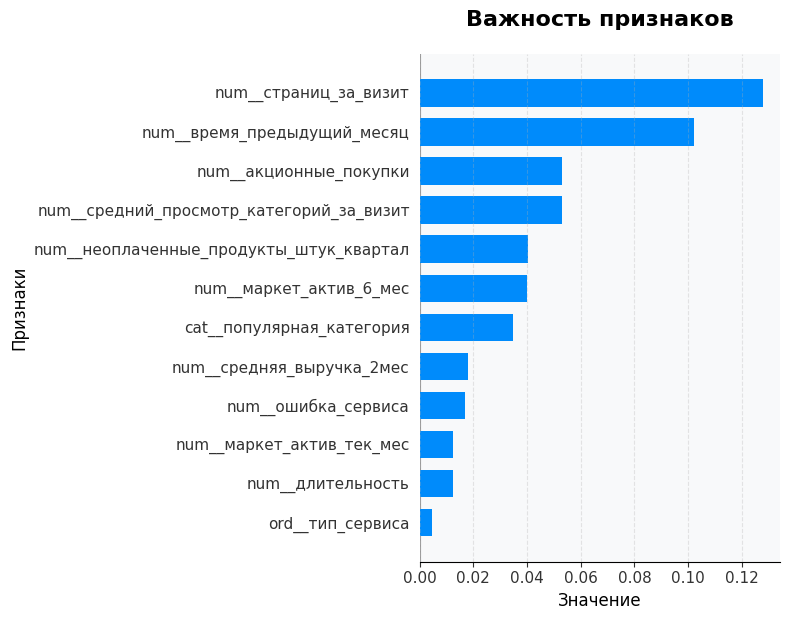

In [169]:
shap.summary_plot(shap_values[:, :, 1], X_test_prep, 
                  plot_type='bar',
                  feature_names=feature_names,
                  max_display=15,
                  show=False)


plt.title('Важность признаков', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Значение', fontsize=12)
plt.ylabel('Признаки', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='x', alpha=0.3, linestyle='--')


plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)


plt.gca().set_facecolor('#f8f9fa')

plt.tight_layout()
plt.show()

Наиболее весомыми признаками, влияющими на активность пользователей являются:

- количество страниц, просмотренных за визит
- время проведенное на сайте за предыдущий месяц
- количество просмотренных категорий за визит
- количество акционных покупок
- количество маркетинговых коммуникаций с клиентом
- количество неплаченных продуктов в корзине

In [170]:
# посмотрим индексы этих признаков
mean_abs_shap = np.mean(np.abs(shap_values.values[:, :, 1]), axis=0)
top_features_idx = np.argsort(mean_abs_shap)[::-1][:20]

print('Признаки:')
for i, idx in enumerate(top_features_idx):
    print(f"{i+1}. {feature_names[idx]} (индекс {idx}): {mean_abs_shap[idx]:.4f}")

Признаки:
1. num__страниц_за_визит (индекс 9): 0.1278
2. num__время_предыдущий_месяц (индекс 10): 0.1021
3. num__акционные_покупки (индекс 5): 0.0532
4. num__средний_просмотр_категорий_за_визит (индекс 6): 0.0529
5. num__неоплаченные_продукты_штук_квартал (индекс 7): 0.0405
6. num__маркет_актив_6_мес (индекс 2): 0.0402
7. cat__популярная_категория (индекс 0): 0.0349
8. num__средняя_выручка_2мес (индекс 11): 0.0179
9. num__ошибка_сервиса (индекс 8): 0.0167
10. num__маркет_актив_тек_мес (индекс 3): 0.0125
11. num__длительность (индекс 4): 0.0123
12. ord__тип_сервиса (индекс 1): 0.0047


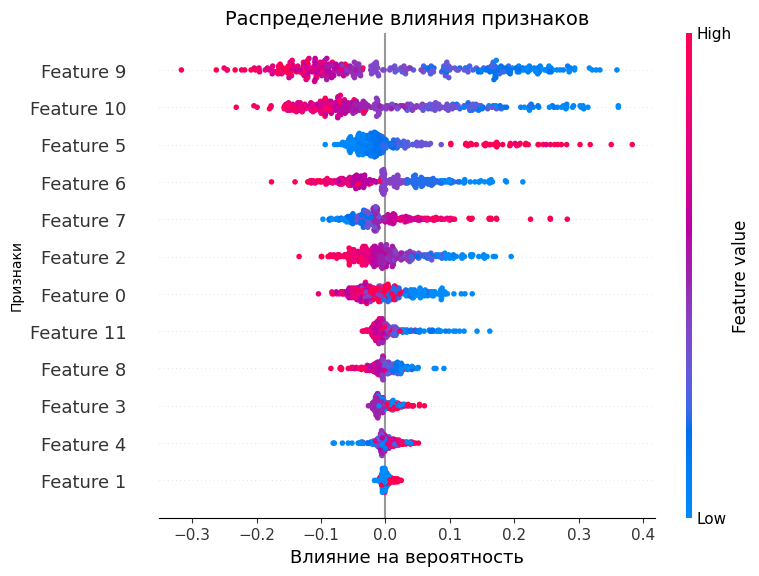

In [171]:
#Рассмотрим другой график важности признаков, который может дать более подробное представление о влиянии на ЦП
shap.plots.beeswarm(shap_values[:, :, 1], max_display=None, show=False)

plt.title('Распределение влияния признаков', fontsize=14)
plt.xlabel('Влияние на вероятность')
plt.ylabel('Признаки')
plt.show()

**Вывод:**
    
    Слабо влияют на предсказание целевого признака:
- тип сервиса
- длительность 
- ошибка сервиса

    Для упрощения модели можно удалить


    Показатели вовлеченности:

- Высокие значения просмотренных страниц за визит уведичивают вероятность активности пользователя, однако этот признак имеет широкий разброс (вариативен для разных пользователей)
- Больше времени проведенного на сайте также предсказывает высокую активность в следующем месяце.
- Разнообразие просматриваемых категорий стабильно поддерживает активность пользователей.
- Акционные покупки сильно влияют на активность у одной группы и имеют слабое влияние на другой
- Важные негативный признак- количество неоплаченных продуктов в корзине. Проблема вызвана не техническими характеристиками (тк корреляции между техническими проблемами и неоплаченными продуктами на прошлом этапе не замечено).


Фиксируемся на:

- num__страниц_за_визит
- num__время_предыдущий_месяц
- num__средний_просмотр_категорий_за_визит
- num__акционные_покупки
- num__неоплаченные_продукты_штук_квартал


# Сегментация покупателей

In [172]:
# Разделим всех потребителей на 4 сегмента по соотношению прибыльности и риска снижения активности
proba = pd.Series(best_model.predict_proba(X)[:, 1], index=X.index, name='prob_churn')

# Добавляем прибыль из money по id
seg = pd.concat([proba, money.loc[X.index, 'прибыль'].rename('profit')], axis=1)

# Значения по квартиклям
risk_thr = seg['prob_churn'].quantile(0.75) # Высокий риск - верхние 25%
profit_thr = seg['profit'].quantile(0.75) # Высокий доход - верхние 25%

seg['segment'] = np.select(
    [
        (seg.prob_churn >= risk_thr) & (seg.profit >= profit_thr),
        (seg.prob_churn < risk_thr) & (seg.profit >= profit_thr),
        (seg.prob_churn >= risk_thr) & (seg.profit < profit_thr),
        (seg.prob_churn < risk_thr) & (seg.profit < profit_thr),
    ],
    [
        'A: Высокий_риск_Высокий доход',
        'B: Стабильные_Высокий доход',
        'C: Высокий_риск_Низкий_доход',
        'D: Стабильные_Низкий_доход'
    ]
)

summary = (
    seg.groupby('segment')
       .agg(
           n=('prob_churn','size'),
           risk_mean=('prob_churn','mean'),
           profit_mean=('profit','mean'),
           profit_sum=('profit','sum')
       )
       .assign(profit_share=lambda d: d.profit_sum / d.profit_sum.sum())
       .sort_values('profit_sum', ascending=False)
)

summary

,n,risk_mean,profit_mean,profit_sum,profit_share
segment,,,,,
D: Стабильные_Низкий_доход,718,0.187072,3546.908078,2546680.0,0.491566
B: Стабильные_Высокий доход,254,0.197653,5254.803150,1334720.0,0.257631
C: Высокий_риск_Низкий_доход,254,0.961378,3663.307087,930480.0,0.179603
A: Высокий_риск_Высокий доход,70,0.964601,5269.571429,368870.0,0.071200


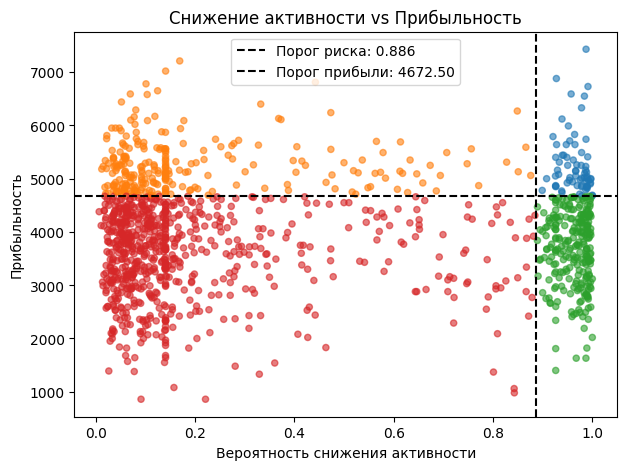

In [173]:
# График соотношения
plt.figure(figsize=(7,5))

colors = seg['segment'].map({
    'A: Высокий_риск_Высокий доход': 'C0',
    'B: Стабильные_Высокий доход': 'C1',
    'C: Высокий_риск_Низкий_доход': 'C2', 
    'D: Стабильные_Низкий_доход': 'C3'
})

plt.scatter(seg.prob_churn, seg.profit, c=colors, alpha=0.6, s=20)
plt.axvline(risk_thr, ls='--', color='black', label=f'Порог риска: {risk_thr:.3f}')
plt.axhline(profit_thr, ls='--', color='black', label=f'Порог прибыли: {profit_thr:.2f}')
plt.xlabel('Вероятность снижения активности')
plt.ylabel('Прибыльность')
plt.title('Снижение активности vs Прибыльность')
plt.legend()
plt.show()

1. Больше всего клиентов стабильно приносят небольшую прибыль, однако суммарно она составляет половину дохода компании - 49%. Предположительно, такой сегмент можно удерживать с минимальными вложениями, сосредоточив усилия на росте среднего чека.
2. 22% прибыли принес сегмент Высокий доход + Стабильные. В этом сегмента самая большая средняя прибыль. 
3. Самый маленький сегмент - покупатели с высоким риском и с высоким доходом. Приосят самую высокую среднюю прибыль. Потеря покупателя из этого сегмента приведёт к более значительной потере. Стоит того, чтобы удержать клиента персональными скидками и доп маркетинговой активностью.
4. Сегмент Высокий Риск + Низкий доход приносит 17%, но средняя прибыль, из-за чего будет выгоднее перевести такого клиента на менее затратные способы удержания.

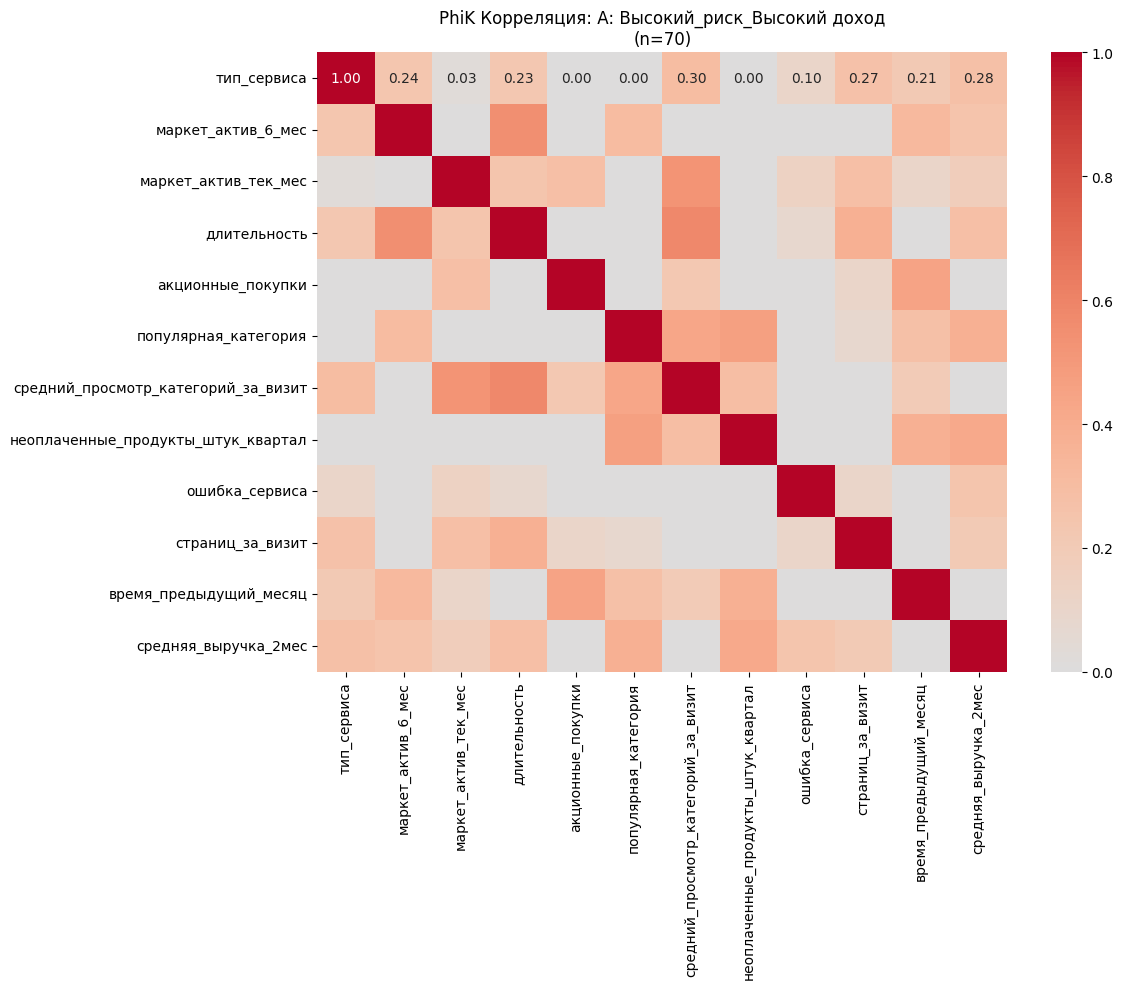

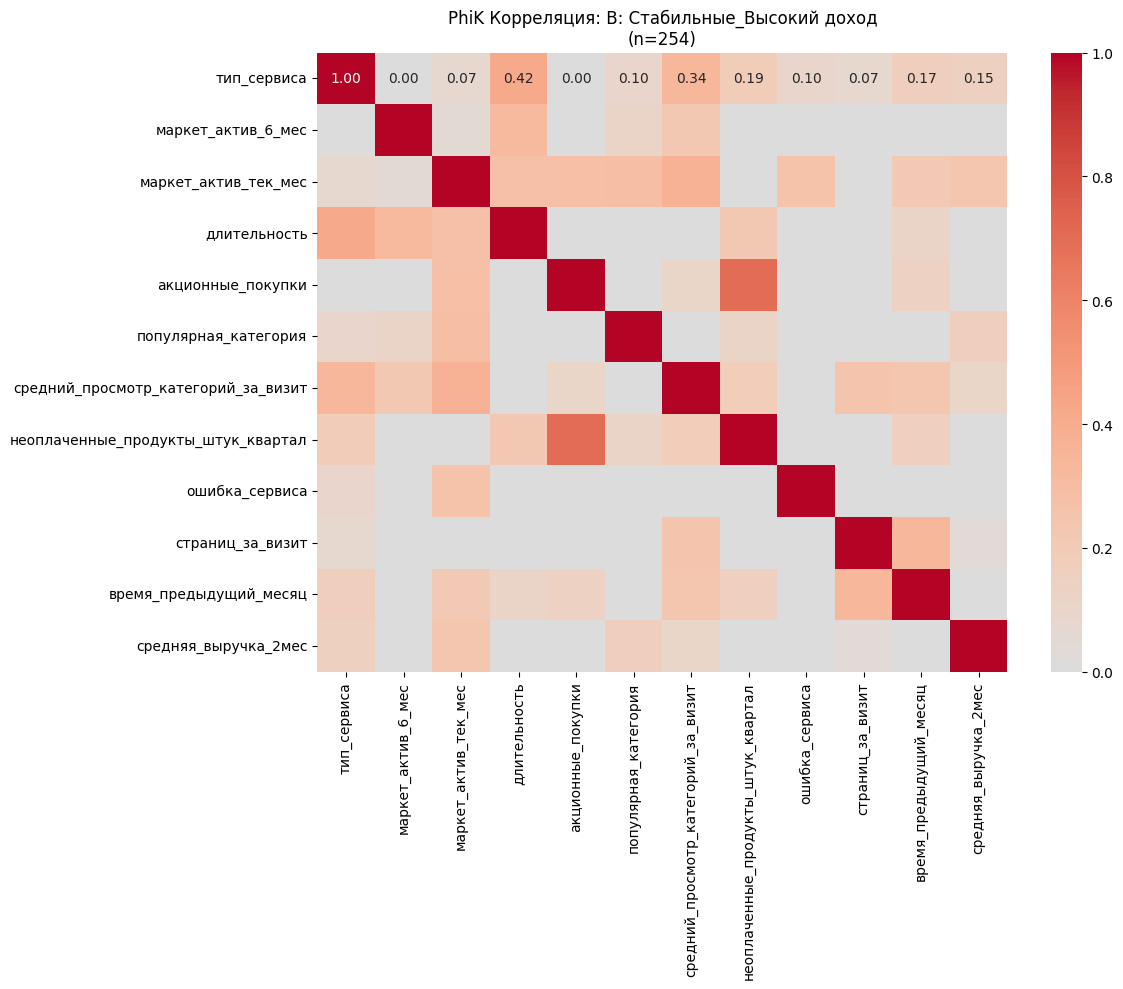

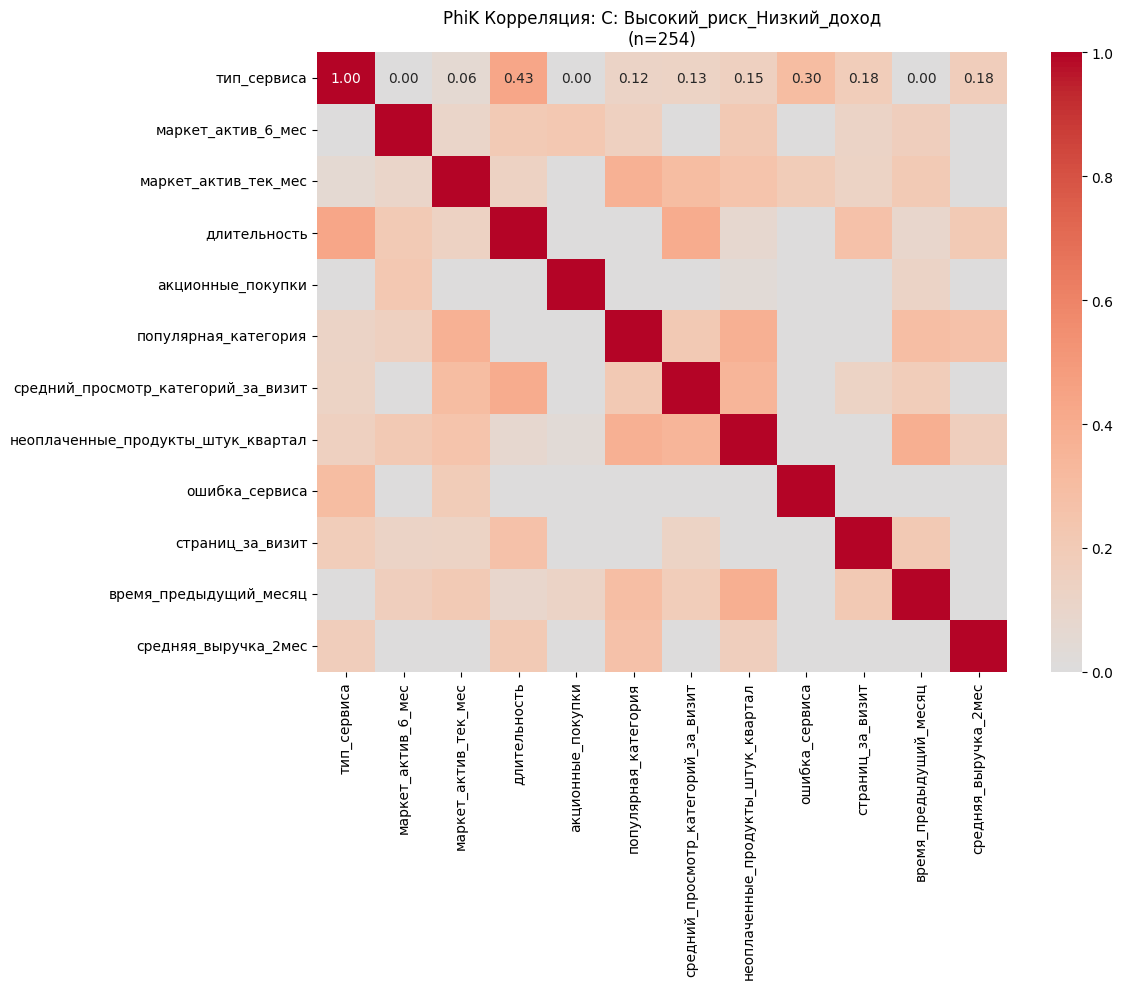

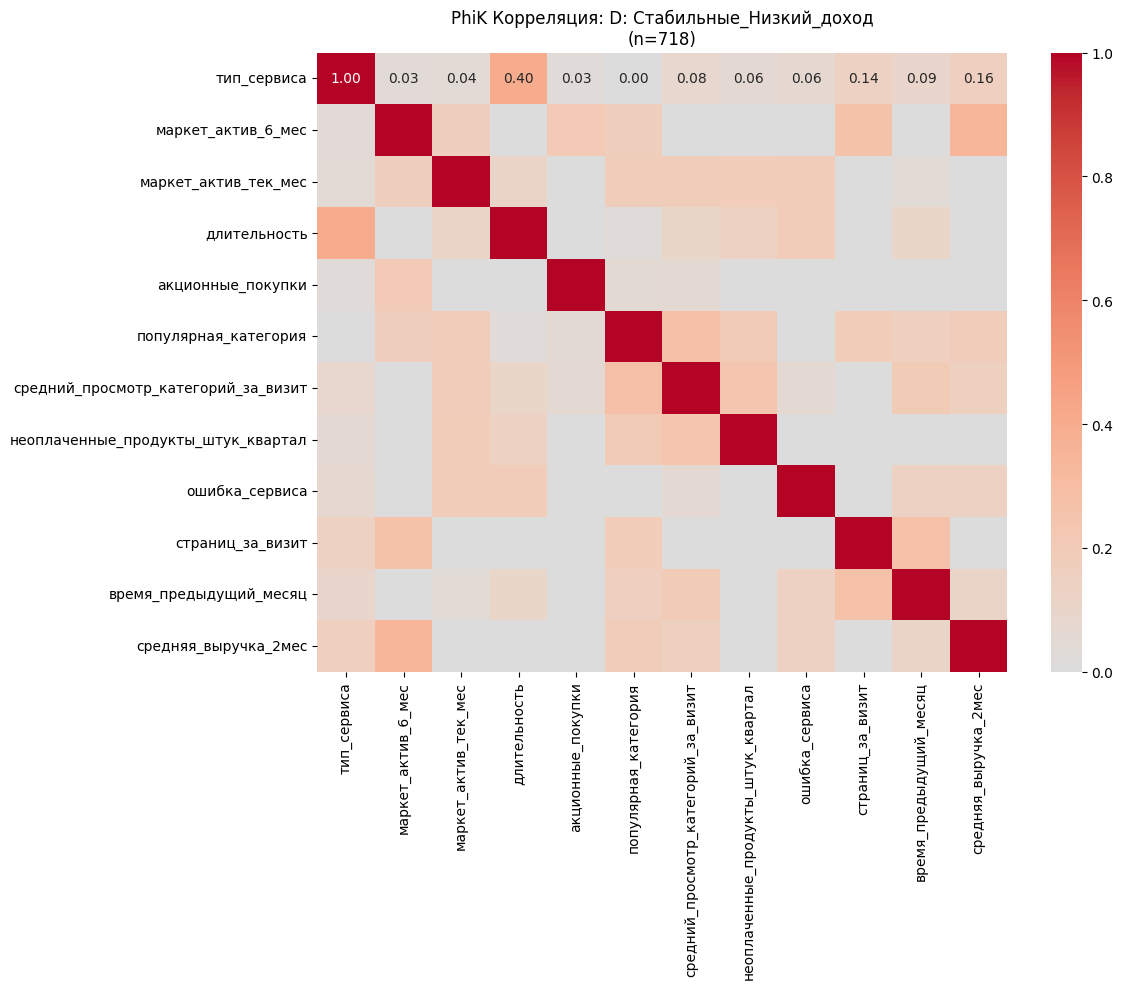

In [174]:
num_cols = [
    'длительность', 
    'акционные_покупки', 
    'маркет_актив_6_мес', 
    'время_предыдущий_месяц', 
    'средняя_выручка_2мес'
]

for segment_name in ['A: Высокий_риск_Высокий доход', 'B: Стабильные_Высокий доход',
                     'C: Высокий_риск_Низкий_доход', 'D: Стабильные_Низкий_доход']:
    
    segment_idx = seg[seg['segment'] == segment_name].index
    segment_data = X.loc[segment_idx]
    
    corr_matrix = segment_data.phik_matrix(
        interval_cols=num_cols
    )
    
    plt.figure(figsize=(12,10))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
    plt.title(f"PhiK Корреляция: {segment_name}\n(n={len(segment_idx)})")
    plt.tight_layout()
    plt.show()

Зависимость между типом сервиса и временем, проведённым с момента регистрации может указывать на то, что посетители с премиальным типом сервиса дольше являтся клиентами.

По всем сегменам кроме D (стабильная низкая выручка) есть зависимость чем больше категорий просматривают - тем больше неоплаченных товаров в корзине. Особенно заметно у сегментов А и С.

**Категория А (риск + высокая выручка):**
- Пытаются обойти ошибки сервиса с помощью навигации на сайте (больше ошибок - больше страниц просматривают)
- Ошибки сервиса снижают будущую активность исходя из ошибок сервиса и времени за прошлый месяц
Таким образом, если есть чат технической поддержки таких пользователей стоит ставить в приоритет.


**Категория B (стабильная высокая выручка):**
- Чем больше времени тратят на сайте тем больше ошибок встречают, однако ошибки сервиса не снижают будущую активность.
- В целом, сегмент достаточно стабилен, устойчив к техническим ошибкам.


**Категория С (риск + низкая выручка):**
- Взаимосвязь просмотренных страниц и неоплаченных продкутов.

**Категория D (стабильная низкая выручка:**
- Аналогично категории B встречается с ошибками, но менее чувствительна к ним.
- Взаимосвязь просмотренных страниц и неоплаченных продкутов.


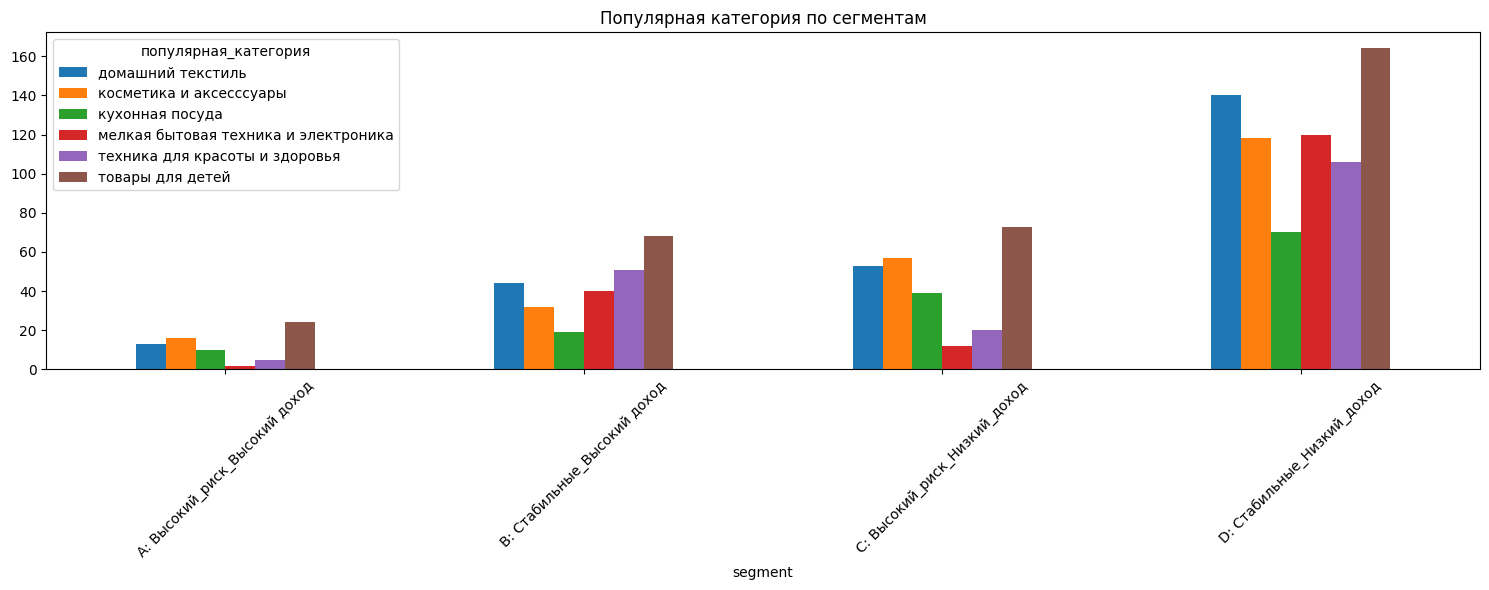

In [175]:
fig, axes = plt.subplots(1, 1, figsize=(15, 6))

# Популярная_категория по сегментам
clean_total.loc[seg.index, 'популярная_категория'] \
    .groupby(seg['segment']) \
    .value_counts() \
    .unstack() \
    .plot(kind='bar', ax=axes)

axes.set_title('Популярная категория по сегментам')
axes.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

    Товары для детей наиболее популярны для всех сегментов, кроме Высокий риск + Высокий доход. 
    Помимо этой категории:
    Сегменг А: примерно равномерная популярность категорий: домашний текстиль, косметика и аксессуары, кухонная посуда
    Сегмент B: также примерно равномерное распределение по категориям, лидируют домашний текстиль, косметика и 
    мелкая бытовая техника
    Сегмент С: лидирует косметика и домашний текстиль
    Сегмент D: домашний текстиль и техника для красоты и здоровья

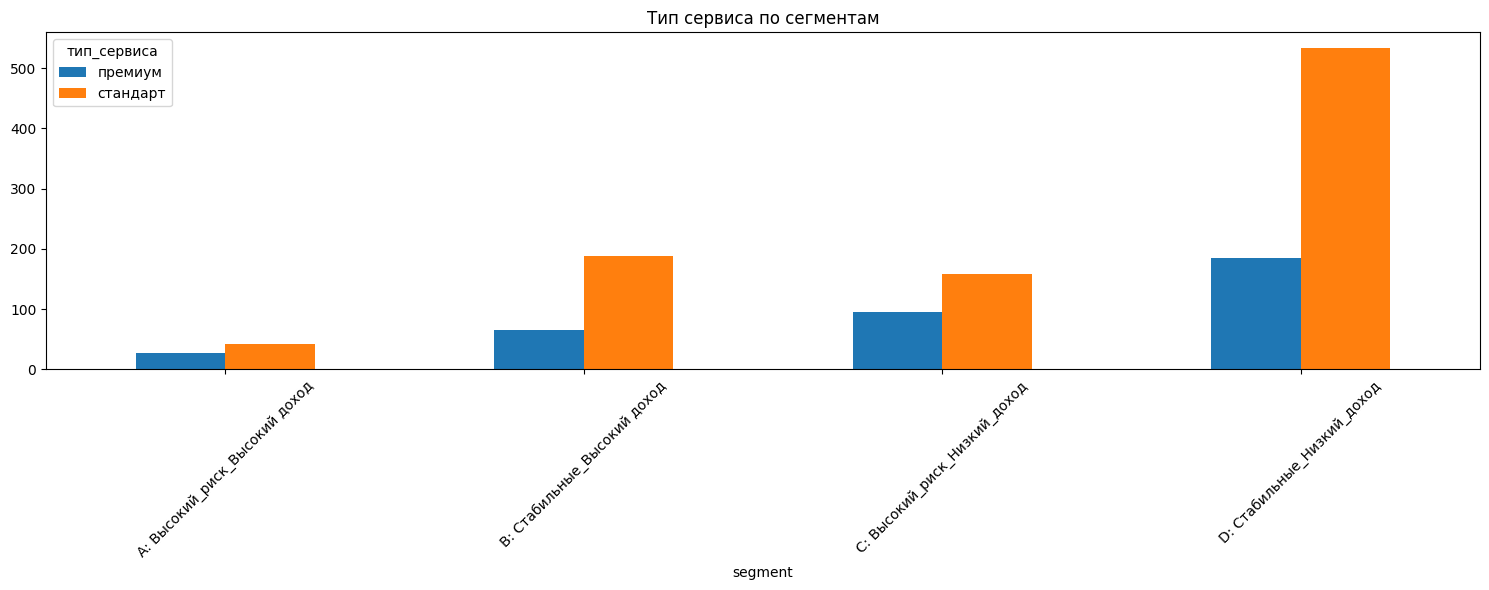

In [176]:
fig, axes = plt.subplots(1, 1, figsize=(15, 6))

# Тип сервиса по сегментам
clean_total.loc[seg.index, 'тип_сервиса'] \
    .groupby(seg['segment']) \
    .value_counts() \
    .unstack() \
    .plot(kind='bar', ax=axes)

axes.set_title('Тип сервиса по сегментам')
axes.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Среди всех категорий пользователей преобладают подписчики типа сервиса "стандарт"

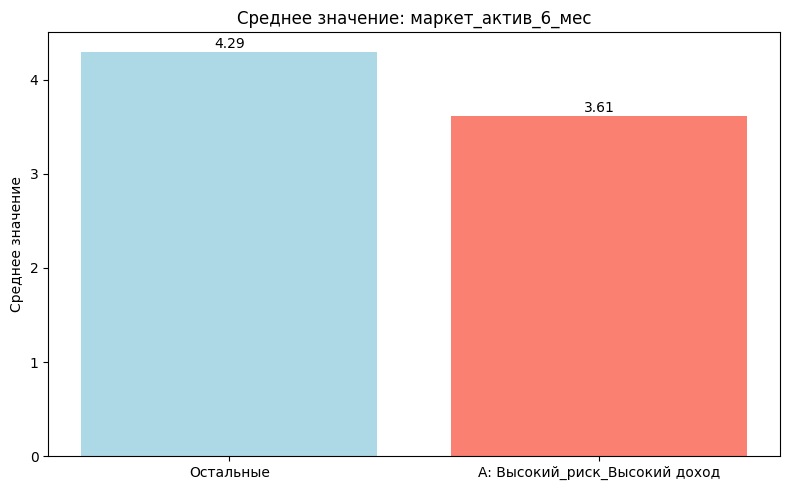

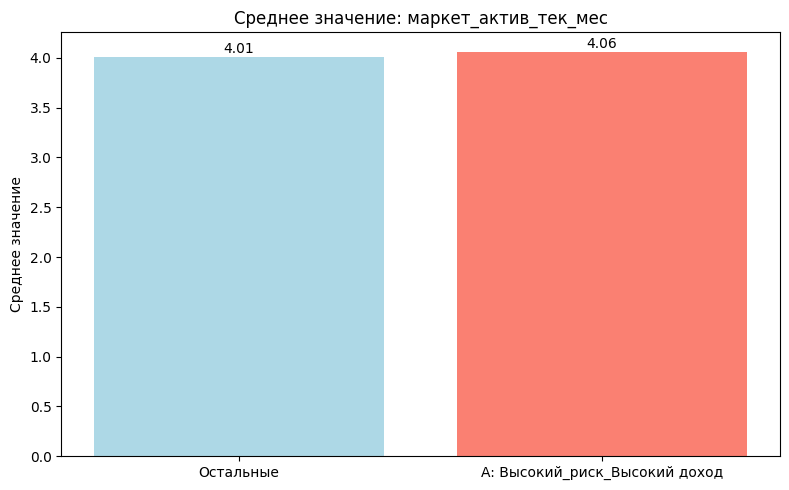

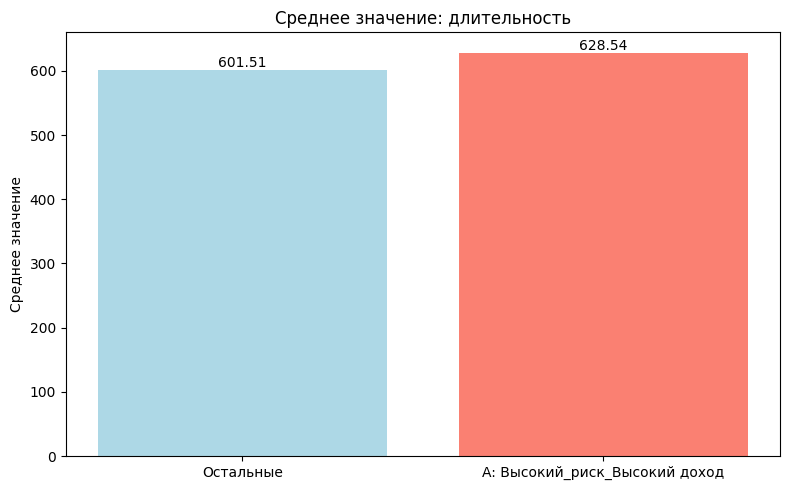

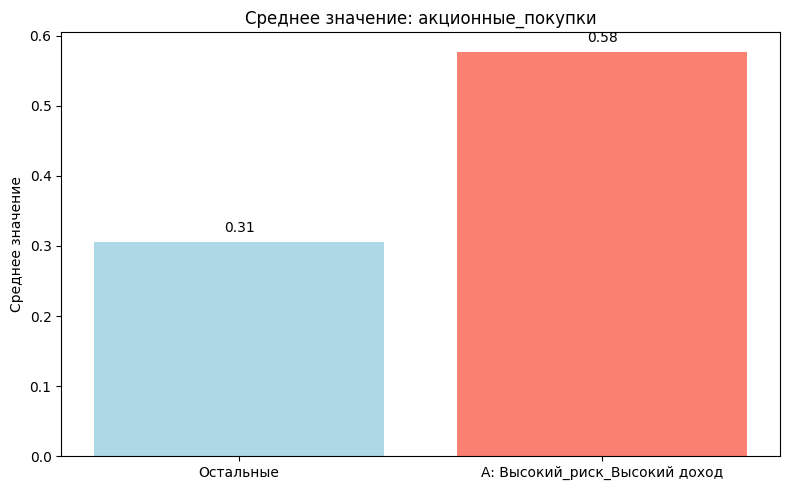

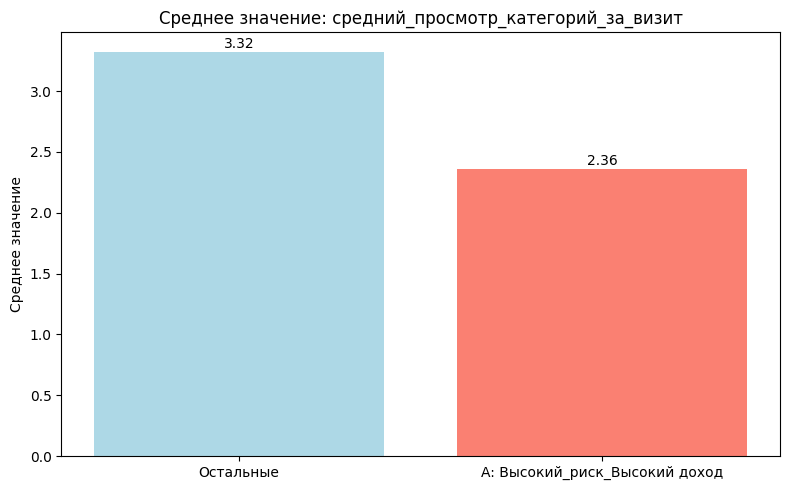

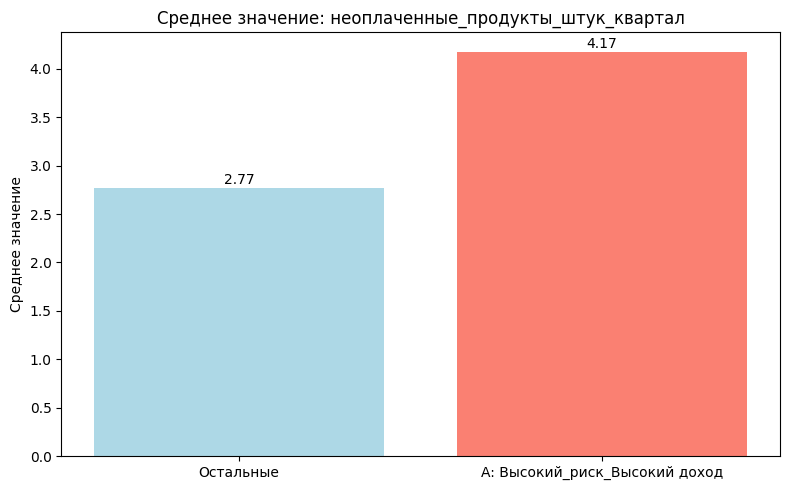

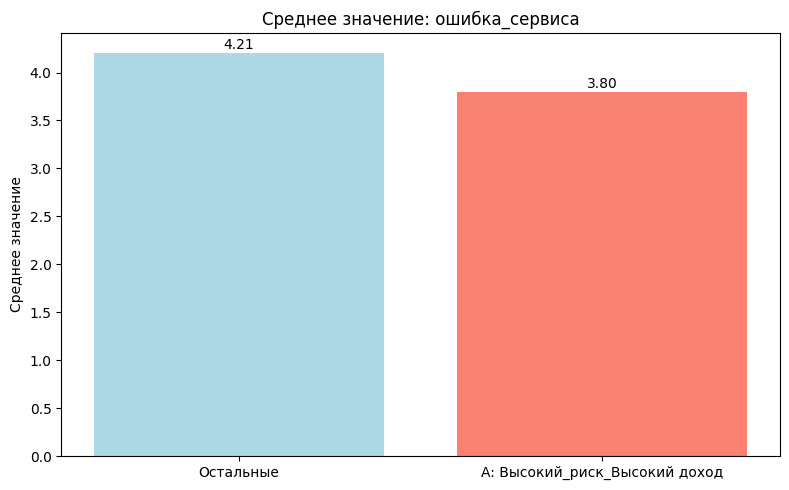

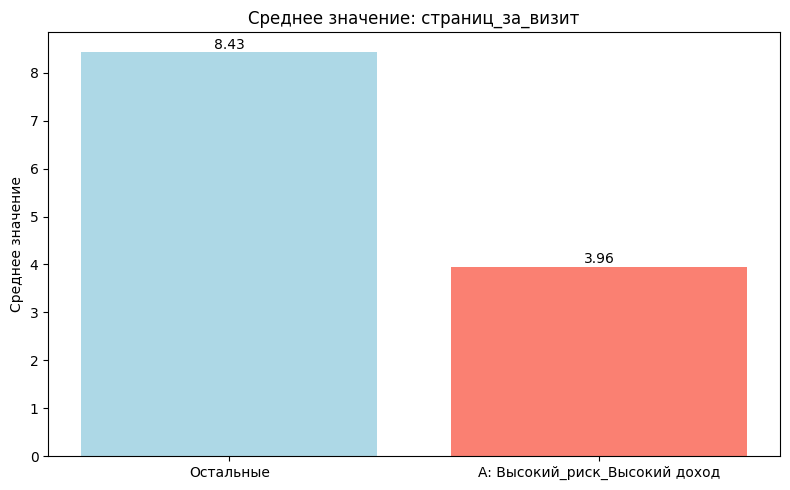

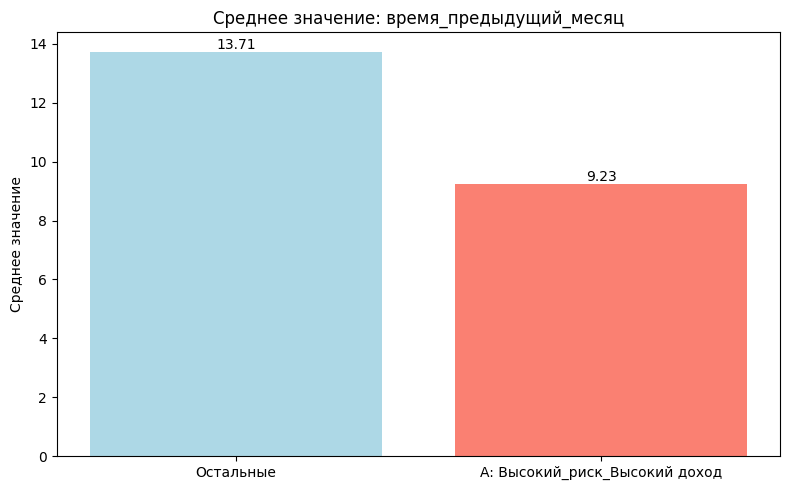

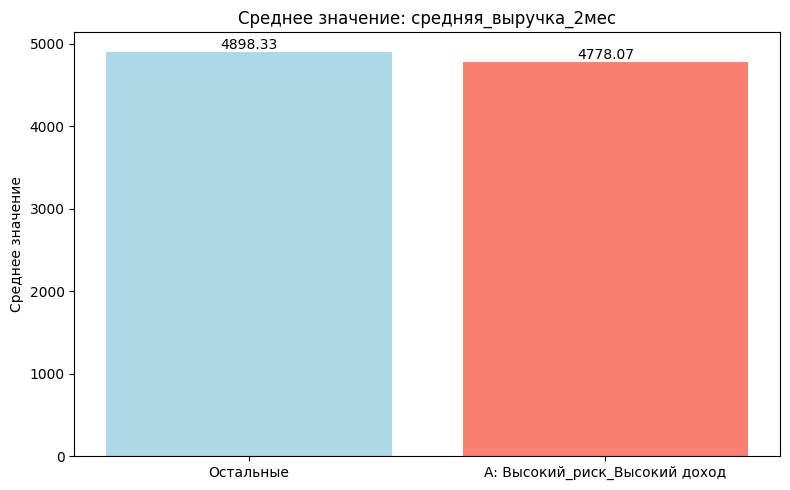

In [177]:
#Используем средние значения для всех числовых признаков
seg_name = 'A: Высокий_риск_Высокий доход'

X_seg = X.copy()
X_seg['segment_group'] = seg['segment'].apply(lambda x: seg_name if x == seg_name else 'Остальные')

num_cols = X_seg.select_dtypes(include=['number']).columns

means = X_seg.groupby('segment_group')[num_cols].mean()

for col in num_cols:
    plt.figure(figsize=(8, 5))
    
    plt.bar(['Остальные', seg_name], 
            [means.loc['Остальные', col], means.loc[seg_name, col]],
            color=['lightblue', 'salmon'])
    
    plt.title(f'Среднее значение: {col}')
    plt.ylabel('Среднее значение')
    
    for i, v in enumerate([means.loc['Остальные', col], means.loc[seg_name, col]]):
        plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

Для высокодоходной группы, находящейся в зоне риска среднее значение акционных покупок выше, чем для остальных.
В качестве акционных предложений можно предложить две лидирующие в этой группе любимые категории товаров: домашний текстиль, косметика и аксессуары.

**Вывод:**


На этом этапе мы добавливи в таблицу значение прибыли от покупателей и выделили 4 сегмента клиентов по средней прибыли и риску их потерять: 
- A: Высокий_доход и Высокий_риск
- B: Высокий_доход и Низкий_риск
- С: Низкий_доход и Высокий_риск
- D: Низкий_доход и Низкий_риск

    Популярные категории немного отличаются у разных сегментов.
    Для удержания возможно включить акции по популярным категориям, кроме товаров для детей. Эта категория популярна почти у всех сегментов и скорее всего спрос на неё не эластичен из-за большого ряда товаров первой необходимости (подгузники и пр). В этой товарной категории возможны скидки на наборы или на сезонные необязательные товары (это утверждение требудет дополнительной проверки).

    Популярные товарные категории среди групп можно использовать чтобы мотивировать подключить премиум подписку, прелставляя её как более легкий способо следить за ассортиментом и ценой интересных товаров.
    
    У всех категорий пользователей есть взаимосвязь между просмотренными категориями или страницами за визит и неоплаченными покупками в корзине. Предположение: возможно покупатели не находят того, что ищут, временно откладывая некоторые варианты в козину, но потом находят их у конкурентов. В таком случае количество неплаченных продуктов в корзине логично влияет на стабильность покупателя тк если постоянно нет подходящего товара - клиент скорее всего уйдёт.
    
    Так как из-за более высокой средней выручки магазину выгоднее удержать покупателя сегмента А - стоит уделить им большее внимание в технической поддержке тк ошибки сервиса у этой аудитории сильнее чем у других аудиторий снижают будущую активность.
    Если покупатель находится в сегменте А таже есть смысл направлять ему персональные скидки в основных любимых 
    категориях (сейчас это домашний текстиль, косметика и аксессуары)
    
    В остальных случаях можно предложить скидки по системе баллов или на за наборы товаров.

# Общий вывод

**Задача:**

- Создать модель, предсказывающую снижение покупательской активности клиента и разработать персональные предложения по удержанию в зависимости от сегмента покупателея.

**Исходные данные:**
    Мы следуюзие исходные данные:
- Данные о поведении покупателя на сайте и его коммуникации с продавцом (/datasets/market_file.csv)
- Данные об общей выручке по каждому покупателю (/datasets/market_money.csv)
- Данные о времени проведенном на сайте(datasets/market_time.csv)
- Данные о прибыли с покупателя за последние 3 месяца(/datasets/money.csv)

В процессе работы:
- Был проведён исследовательский анализ данных и удалены выбросы и неявные дубликаты.
- Объединение таблиц
- Корреляционный анализ: удалены утечки и удалены признаки с нулевой корреляцией с ЦП. Был сформирован агрегированный признак.
- Кодирование признаков
- С помощью пайплайна с GridSearch нашли модель с лушими показателями.
- Выделили сегменты покупателей

**Лучшая модель:**
Лучшая модель - SVM (C=1, probability=True)
Метрика roc-auc = 0.902


Общие предложения по удержанию пользователей: провести ревью своего ассортимента и ассортимента конкурентов. 
Возможно, ассортимент является одной из причин неоплаченных товаров в корзине и ухода части покупателей.
Ещё одна причина - слабая рекомендательная система/система навигации из-за чего пользователь после долгих поисков не может найти нужный товар, в то время как он присутствует в магазине. Если проблемы с ассортиментом нет - рекомендуется вложить ресурсы в оптимизацию навигации.

Для пользователей с высокой выручкой, находящихся в зоне риска рекомендуется:
- первостепенно предоставлять техническую поддержку, тк ошибки сервиса сильнее чем у других аудиторий снижают будущую активность.
- возможно разработать порог выручки, при которой клиенту (если он в зоне риска) будут поступать органиченные маркетинговые рассылки (или предложения от менеджера) чтобы удержать достаточно прибыльного покупателя.

Стоит обратить внимание на пользователей с подпиской премиум, возможно, разработать систему бонусов с баллами или на наборы товаров, которые работают только с ней. Это также может мотивировать покупателей, берущим товары преимущественно со скидками брать товары с белым ценником, рассчитывая на отложенный возврат средств при последующих покупках.